In [1]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')
sys.path.append('..')

# Maths
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# ML
from sklearn.metrics import classification_report, confusion_matrix
from errors import MAE

# Utilities
import h5py
import json
import project_utils as utils

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
colorList = cosmostyle.color_cycle

In /home/helfrech/.config/matplotlib/stylelib/cosmo.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/helfrech/.config/matplotlib/stylelib/cosmoLarge.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


# TODO: turn plotting and classification stats into functions

# Analysis setup

In [2]:
# Load SOAP cutoffs
with open('../../Processed_Data/soap_hyperparameters.json', 'r') as f:
    soap_hyperparameters = json.load(f)
    
cutoffs = soap_hyperparameters['interaction_cutoff']

In [3]:
# Load train and test indices
idxs_deem_train = np.loadtxt('../../Processed_Data/DEEM_10k/train.idxs', dtype=int)
idxs_deem_test = np.loadtxt('../../Processed_Data/DEEM_10k/test.idxs', dtype=int)

n_deem_train = idxs_deem_train.size
n_deem_test = idxs_deem_test.size
n_deem = n_deem_train + n_deem_test

In [4]:
idxs_iza_train = np.loadtxt('../../Processed_Data/IZA_226/train.idxs', dtype=int)
idxs_iza_test = np.loadtxt('../../Processed_Data/IZA_226/test.idxs', dtype=int)

In [5]:
# Load IZA cantons
cantons_iza = np.loadtxt('../../Raw_Data/GULP/IZA_226/cantons.txt', usecols=1, dtype=int)
RWY = np.nonzero(cantons_iza == 4)[0][0]
cantons_iza = np.delete(cantons_iza, RWY)
n_iza = len(cantons_iza)

In [6]:
# Make dummy DEEM cantons
cantons_deem = np.ones(n_deem, dtype=int) * 4

In [7]:
# Build set of "master" canton labels
cantons_train = {}
cantons_test = {}

cantons_train[4] = np.concatenate((cantons_iza[idxs_iza_train], cantons_deem[idxs_deem_train]))
cantons_test[4] = np.concatenate((cantons_iza[idxs_iza_test], cantons_deem[idxs_deem_test]))

cantons_train[2] = np.concatenate((np.ones(len(idxs_iza_train), dtype=int),
                                   np.ones(len(idxs_deem_train), dtype=int) * 2))
cantons_test[2] = np.concatenate((np.ones(len(idxs_iza_test), dtype=int),
                                  np.ones(len(idxs_deem_test), dtype=int) * 2))

In [8]:
# Load dummy Deem cantons to test the "null" case -- i.e., the SVC shouldn't be able to classify
# a random splitting of DEEM
dummy_cantons_deem_2 = np.loadtxt('../../Processed_Data/DEEM_10k/dummy_cantons_2-class.dat')
dummy_cantons_deem_4 = np.loadtxt('../../Processed_Data/DEEM_10k/dummy_cantons_4-class.dat')
    
dummy_cantons_deem_train = {2: dummy_cantons_deem_2[idxs_deem_train],
                            4: dummy_cantons_deem_4[idxs_deem_train]}
dummy_cantons_deem_test = {2: dummy_cantons_deem_2[idxs_deem_test],
                           4: dummy_cantons_deem_4[idxs_deem_test]}

In [9]:
class_names = {}
class_names[2] = ['IZA', 'DEEM']
class_names[4] = ['IZA1', 'IZA2', 'IZA3', 'DEEM']

In [22]:
#ticklabels = {2: ['IZA', 'DEEM'],
#              4: ['IZA1', 'IZA2', 'IZA3', 'DEEM']}
ticklabels = {2: ['DEEM1', 'DEEM2'],
              4: ['DEEM1', 'DEEM2', 'DEEM3', 'DEEM4']}

# Kernel Models

In [23]:
deem_name = 'DEEM_10k'
iza_name = 'IZA_226onDEEM_10k'
deem_dir = f'../../Processed_Data/{deem_name}/Data'
iza_dir = f'../../Processed_Data/{iza_name}/Data'

## Plotting

===== 3.5 | Linear | 4-Class =====


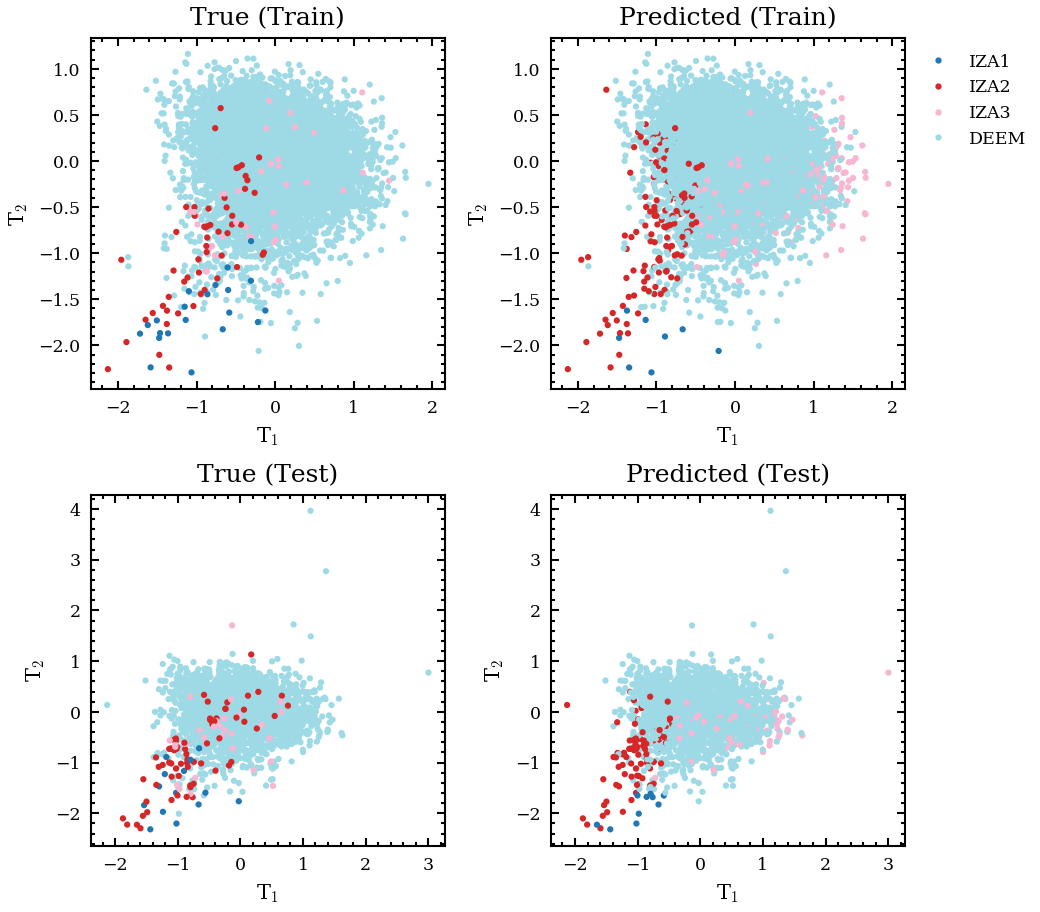

===== 3.5 | Gaussian | 4-Class =====


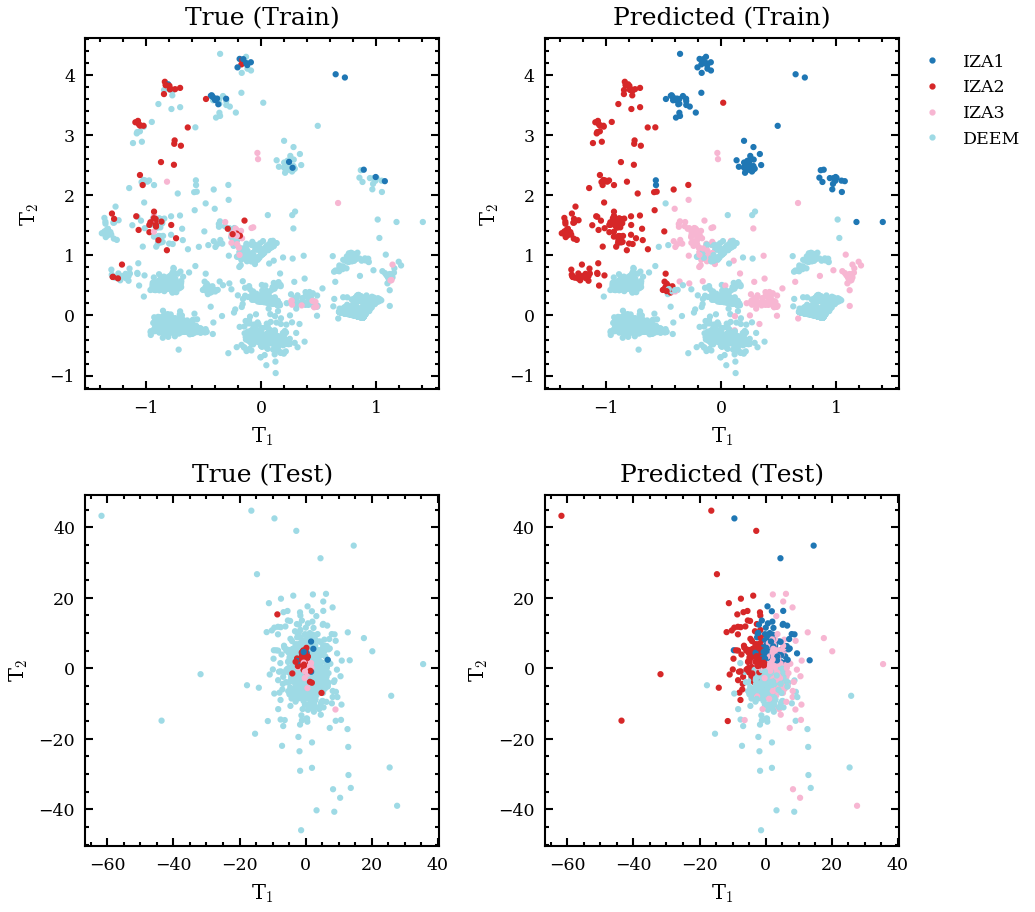

===== 6.0 | Linear | 4-Class =====


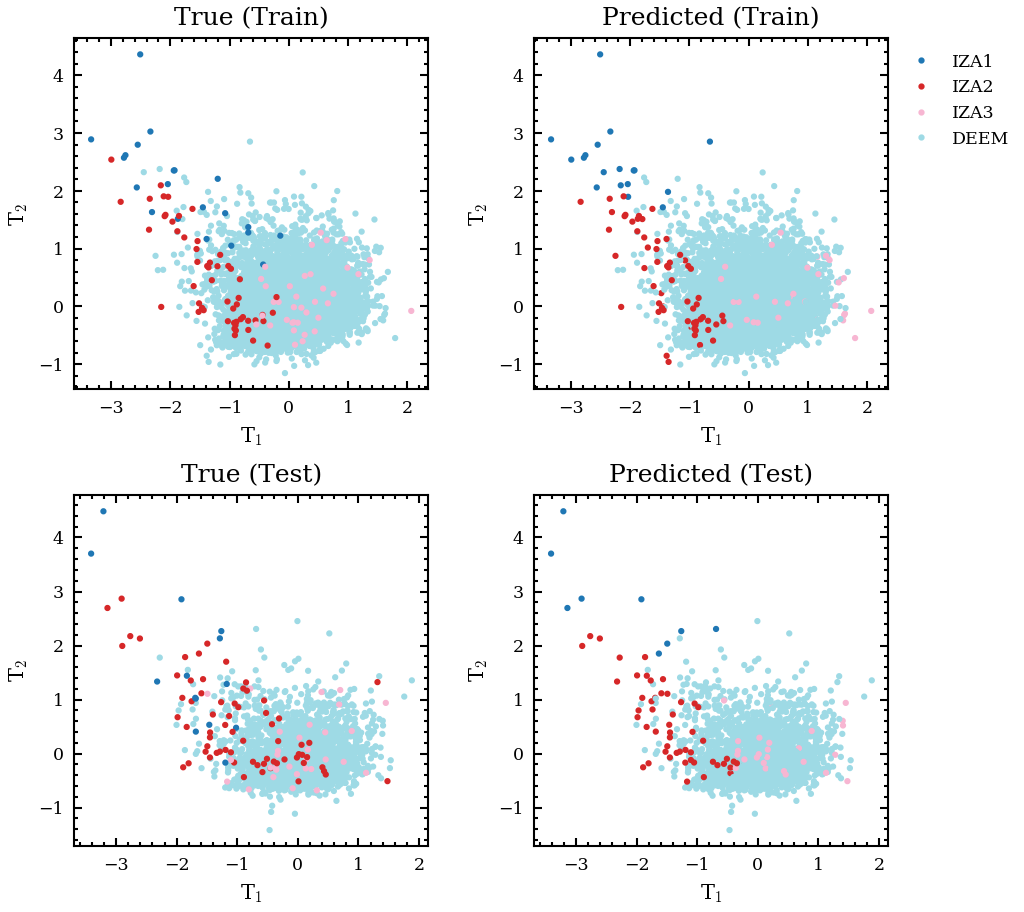

===== 6.0 | Gaussian | 4-Class =====


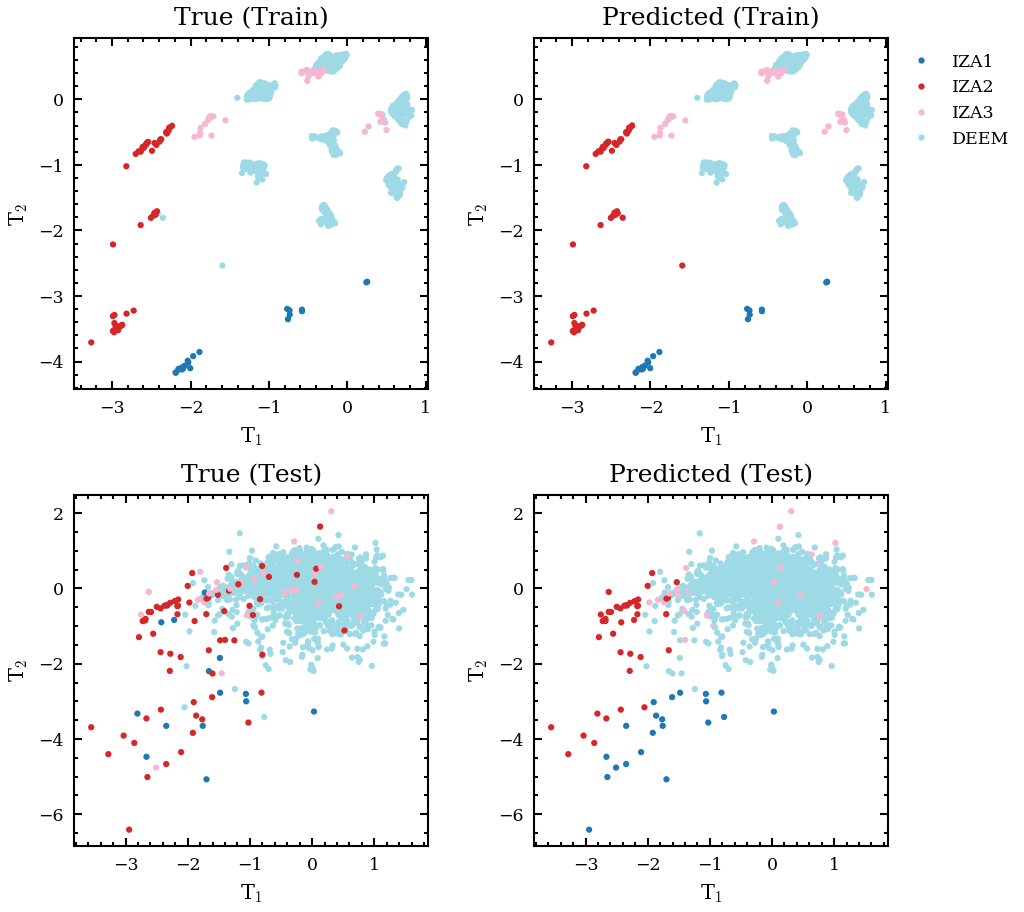

In [24]:
for cutoff in cutoffs:
    for kernel_type in ('linear', 'gaussian'):
        kernel_name = kernel_type.capitalize()
        for n_cantons in [4]: #(2, 4):
            data_dir = f'Kernel_Models/{kernel_name}/KSVC-KPCovR/{n_cantons}-Class'
            
            print(f'===== {cutoff} | {kernel_name} | {n_cantons}-Class =====')
    
            # Load projections
            deem_file = f'{deem_dir}/{cutoff}/{data_dir}/pcovr_structures.hdf5'
            T_deem = utils.load_structures_from_hdf5(deem_file, datasets=None, concatenate=True)

            iza_file = f'{iza_dir}/{cutoff}/{data_dir}/pcovr_structures.hdf5'
            T_iza = utils.load_structures_from_hdf5(iza_file, datasets=None, concatenate=True)

            # Load predicted cantons
            deem_file = f'{deem_dir}/{cutoff}/{data_dir}/pcovr_structure_cantons.dat'
            predicted_cantons_deem = np.loadtxt(deem_file, dtype=int)

            iza_file = f'{iza_dir}/{cutoff}/{data_dir}/pcovr_structure_cantons.dat'
            predicted_cantons_iza = np.loadtxt(iza_file, dtype=int)

            fig = plt.figure(figsize=(7.0, 7.0))
            axs_true_train = fig.add_subplot(2, 2, 1)
            axs_predicted_train = fig.add_subplot(2, 2, 2)
            axs_true_test = fig.add_subplot(2, 2, 3)
            axs_predicted_test = fig.add_subplot(2, 2, 4)
            scatter_opts = dict(cmap='tab20', vmin=1, vmax=4)
            df_idx = 0

            axs_true_train.scatter(T_deem[idxs_deem_train, 0], T_deem[idxs_deem_train, 1], 
                        c=cantons_deem[idxs_deem_train], zorder=2, **scatter_opts)
            axs_true_train.scatter(T_iza[idxs_iza_train, 0], T_iza[idxs_iza_train, 1], 
                        c=cantons_iza[idxs_iza_train], zorder=3, **scatter_opts)

            axs_predicted_train.scatter(T_deem[idxs_deem_train, 0], T_deem[idxs_deem_train, 1], 
                        #c=df_deem_train[:, df_idx])
                        c=predicted_cantons_deem[idxs_deem_train], zorder=2, **scatter_opts)
            axs_predicted_train.scatter(T_iza[idxs_iza_train, 0], T_iza[idxs_iza_train, 1], 
                        #c=df_iza_train[:, df_idx])
                        c=predicted_cantons_iza[idxs_iza_train], zorder=3, **scatter_opts)

            axs_true_test.scatter(T_deem[idxs_deem_test, 0], T_deem[idxs_deem_test, 1],
                    c=cantons_deem[idxs_deem_test], zorder=2, **scatter_opts)
            axs_true_test.scatter(T_iza[idxs_iza_test, 0], T_iza[idxs_iza_test, 1],
                    c=cantons_iza[idxs_iza_test], zorder=3, **scatter_opts)

            axs_predicted_test.scatter(T_deem[idxs_deem_test, 0], T_deem[idxs_deem_test, 1],
                    #c=df_deem_test[:, df_idx])
                    c=predicted_cantons_deem[idxs_deem_test], zorder=2, **scatter_opts)
            axs_predicted_test.scatter(T_iza[idxs_iza_test, 0], T_iza[idxs_iza_test, 1],
                    #c=df_iza_test[:, df_idx])
                    c=predicted_cantons_iza[idxs_iza_test], zorder=3, **scatter_opts)

            handles = [Line2D([0], [0], c=plt.get_cmap('tab20')(0.0), marker='o', linewidth=0),
                       Line2D([0], [0], c=plt.get_cmap('tab20')(0.33), marker='o', linewidth=0),
                       Line2D([0], [0], c=plt.get_cmap('tab20')(0.67), marker='o', linewidth=0),
                       Line2D([0], [0], c=plt.get_cmap('tab20')(1.0), marker='o', linewidth=0)]

            labels = ['IZA1', 'IZA2', 'IZA3', 'DEEM']
            axs_predicted_train.legend(handles=handles, labels=labels, 
                                       loc='upper left', bbox_to_anchor=(1.0, 1.0))

            for ax in (axs_true_train, axs_predicted_train, axs_true_test, axs_predicted_test):
                ax.set_xlabel(r'T$_1$')
                ax.set_ylabel(r'T$_2$')

            axs_true_train.set_title('True (Train)')
            axs_predicted_train.set_title('Predicted (Train)')
            axs_true_test.set_title('True (Test)')
            axs_predicted_test.set_title('Predicted (Test)')

            fig.subplots_adjust(wspace=0.3, hspace=0.3)

            # TODO: change filepath
            #fig.savefig(f'../Results/{cutoff}/svm-kpcovr.png', bbox_inches='tight')

            plt.show()

## Classification statistics

### KernelSVC

In [25]:
for cutoff in cutoffs:
    for kernel_type in ('linear', 'gaussian'):
        kernel_name = kernel_type.capitalize()
        for n_cantons in (2, 4):
            data_dir = f'Kernel_Models/{kernel_name}/KSVC-KPCovR/{n_cantons}-Class'
            
            print(f'===== {cutoff} | {kernel_name} | {n_cantons}-Class =====')
            
            predicted_cantons_iza = \
                np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int)
            predicted_cantons_deem = \
                np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int)

            predicted_cantons_train = np.concatenate((predicted_cantons_iza[idxs_iza_train],
                                                      predicted_cantons_deem[idxs_deem_train]))
            predicted_cantons_test = np.concatenate((predicted_cantons_iza[idxs_iza_test],
                                                     predicted_cantons_deem[idxs_deem_test]))

            matrix_train = confusion_matrix(cantons_train[n_cantons], predicted_cantons_train)
            matrix_test = confusion_matrix(cantons_test[n_cantons], predicted_cantons_test)
            
            print('----- Train -----')
            print(classification_report(cantons_train[n_cantons], predicted_cantons_train,
                                        zero_division=0))
            print('Train accuracy:', np.sum(np.diag(matrix_train)) / np.sum(matrix_train))
            print()
            print(matrix_train)
            print()

            print('----- Test -----')
            print(classification_report(cantons_test[n_cantons], predicted_cantons_test,
                                        zero_division=0))
            print('Test accuracy:', np.sum(np.diag(matrix_test)) / np.sum(matrix_test))
            print()
            print(matrix_test)
            print()

===== 3.5 | Linear | 2-Class =====
----- Train -----
              precision    recall  f1-score   support

           1       0.19      0.99      0.31       112
           2       1.00      0.94      0.97      7750

    accuracy                           0.94      7862
   macro avg       0.59      0.96      0.64      7862
weighted avg       0.99      0.94      0.96      7862

Train accuracy: 0.9385652505723734

[[ 111    1]
 [ 482 7268]]

----- Test -----
              precision    recall  f1-score   support

           1       0.39      0.90      0.54       113
           2       0.99      0.93      0.96      2250

    accuracy                           0.93      2363
   macro avg       0.69      0.92      0.75      2363
weighted avg       0.97      0.93      0.94      2363

Test accuracy: 0.9267879813796022

[[ 102   11]
 [ 162 2088]]

===== 3.5 | Linear | 4-Class =====
----- Train -----
              precision    recall  f1-score   support

           1       0.15      0.95      0.

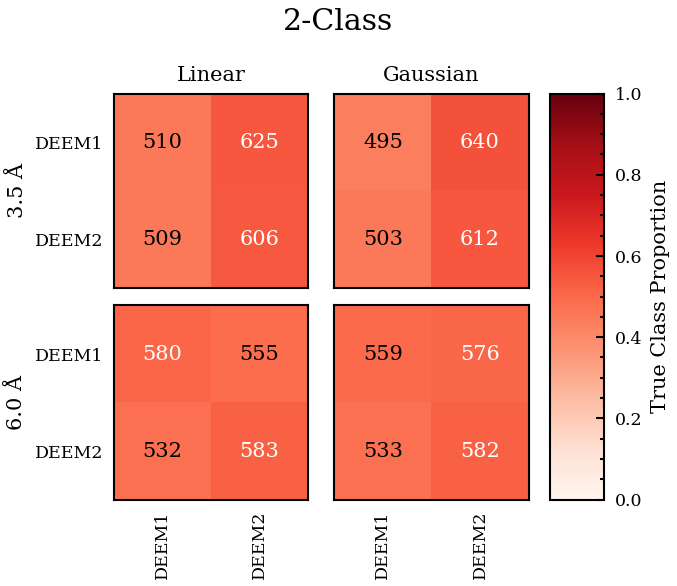

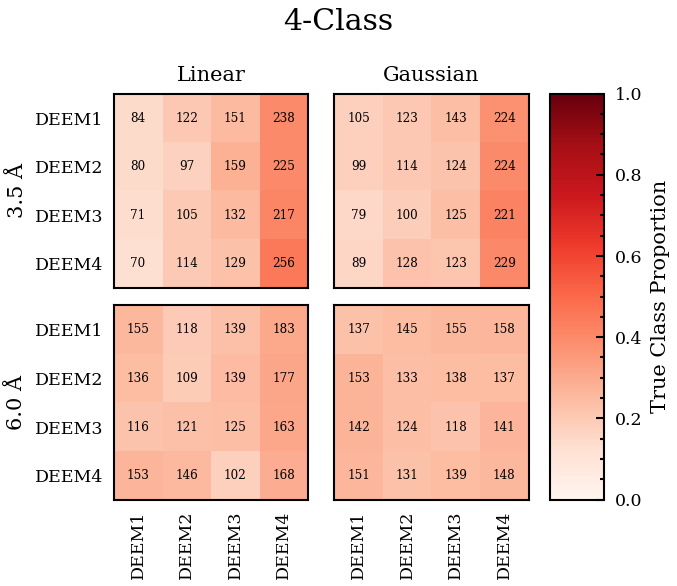

In [26]:
fig_2class = plt.figure(figsize=(4.5, 3.5), constrained_layout=True)
fig_4class = plt.figure(figsize=(4.5, 3.5), constrained_layout=True)

n_rows = 2
n_cols = 2

vmin = 0.0 #-len(idxs_iza_test)
vmax = 1.0 #len(idxs_iza_test)

width_ratios = np.ones(n_cols + 1)
width_ratios[-1] = 0.25

for fig, n_cantons in zip((fig_2class, fig_4class), (2, 4)):
    gs = fig.add_gridspec(nrows=n_rows, ncols=n_cols+1, 
                          width_ratios=width_ratios,
                          hspace=0.05, wspace=0.05)
    axes = np.array([[fig.add_subplot(gs[i, j]) for j in range(0, n_cols)] for i in range(0, n_rows)])
    row_idx = 0
    for cutoff in cutoffs:
        col_idx = 0
        for kernel_type in ('linear', 'gaussian'):
            kernel_name = kernel_type.capitalize()

            # Prepare outputs
            data_dir = f'Kernel_Models/{kernel_name}/KSVC-KPCovR/{n_cantons}-Class'

#             predicted_cantons_iza = \
#                 np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int)
#             predicted_cantons_deem = \
#                 np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int)

#             predicted_cantons_train = np.concatenate((predicted_cantons_iza[idxs_iza_train],
#                                                       predicted_cantons_deem[idxs_deem_train]))
#             predicted_cantons_test = np.concatenate((predicted_cantons_iza[idxs_iza_test],
#                                                      predicted_cantons_deem[idxs_deem_test]))

            dummy_cantons = np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/dummy_svc_structure_cantons.dat', dtype=int) ###
            predicted_cantons_train = dummy_cantons[idxs_deem_train] ###
            predicted_cantons_test = dummy_cantons[idxs_deem_test] ###
            
#             matrix_train = confusion_matrix(cantons_train[n_cantons], predicted_cantons_train)
#             matrix_test = confusion_matrix(cantons_test[n_cantons], predicted_cantons_test)

            matrix_train = confusion_matrix(dummy_cantons_deem_train[n_cantons], predicted_cantons_train) ###
            matrix_test = confusion_matrix(dummy_cantons_deem_test[n_cantons], predicted_cantons_test) ###

            matrix_ref = np.zeros((n_cantons, n_cantons), dtype=int)

            for i in range(0, n_cantons):
                #matrix_ref[i, i] = np.count_nonzero(cantons_test[n_cantons] == (i + 1))
                matrix_ref[i, i] = np.count_nonzero(dummy_cantons_deem_test[n_cantons] == (i + 1)) ###

            matrix_norm = matrix_test / np.diagonal(matrix_ref)[:, np.newaxis]

            ax = axes[row_idx, col_idx]
            ax.imshow(matrix_norm, cmap='Reds', vmin=vmin, vmax=vmax)

            if n_cantons == 2:
                text_size = 'medium'
            else:
                text_size = 'xx-small'

            for i in range(0, n_cantons):
                for j in range(0, n_cantons):
                    if matrix_norm[i, j] > (0.5 * vmax):
                        text_color = 'w'
                    else:
                        text_color = 'k'
                    ax.text(j, i, f'{matrix_test[i, j]:d}', 
                            horizontalalignment='center', verticalalignment='center',
                            color=text_color, fontsize=text_size)

            ax.set_xticks(np.arange(0, n_cantons))
            ax.set_yticks(np.arange(0, n_cantons))

            ax.tick_params(axis='both', which='both', 
                           left=False, bottom=False, right=False, top=False,
                           labelleft=False, labelbottom=False, labelright=False, labeltop=False)

            if col_idx == 0:
                ax.set_ylabel(f'{cutoff} ' + u'\u00c5')
                ax.set_yticklabels(ticklabels[n_cantons])
                ax.tick_params(axis='y', which='both', labelleft=True)

            if row_idx == 0:
                ax.set_title(f'{kernel_name}', fontsize='medium')
            elif row_idx == (n_rows - 1):
                ax.set_xticklabels(ticklabels[n_cantons], rotation=90)
                ax.tick_params(axis='x', which='both', labelbottom=True)

            col_idx += 1
        
        row_idx += 1        
    
#     cp_xy = (0.5, 1.3)
#     cp_power_bar_frac = -0.02
#     cp_radial_bar_frac = cp_power_bar_frac * 3
#     cp_power = ConnectionPatch(xyA=cp_xy, coordsA=axes[0, 0].transAxes,
#                                xyB=cp_xy, coordsB=axes[0, 6].transAxes,
#                                connectionstyle=f'bar,fraction={cp_power_bar_frac}')
#     cp_radial = ConnectionPatch(xyA=cp_xy, coordsA=axes[0, 7].transAxes,
#                                 xyB=cp_xy, coordsB=axes[0, 9].transAxes,
#                                connectionstyle=f'bar,fraction={cp_radial_bar_frac}')
    
#     n_power = len(group_names['power'])
#     n_radial = len(group_names['radial'])
    
#     power_label_ax = axes[0, n_power // 2]
#     if n_power % 2 == 0:
#         power_shift = 0.5
#     else:
#         power_shift = 0.0
        
#     radial_label_ax = axes[0, n_radial // 2 + n_power]
#     if n_radial % 2 == 0:
#         radial_shift = 0.5
#     else:
#         radial_shift = 0.0
    
#     fig.text(0.5 - power_shift, 1.65, 'Power Spectrum',
#              horizontalalignment='center', verticalalignment='center',
#              transform=power_label_ax.transAxes, fontsize='large')
    
#     fig.text(0.5 - radial_shift, 1.65, 'Radial Spectrum',
#              horizontalalignment='center', verticalalignment='center',
#              transform=radial_label_ax.transAxes, fontsize='large')
    
    cax = fig.add_subplot(gs[:, -1])
    cb = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap='Reds'), 
                      cax=cax)
    cb.set_label('True Class Proportion')
    
#     fig.add_artist(cp_power)
#     fig.add_artist(cp_radial)
    fig.suptitle(f'{n_cantons}-Class', y=1.1)
    
    #fig.savefig(f'../../Results/svc_confusion_matrices_{n_cantons}-class_kernel.pdf', bbox_inches='tight')
    fig.savefig(f'../../Results/dummy_svc_confusion_matrices_{n_cantons}-class_kernel.pdf', bbox_inches='tight')
    
plt.show()

### KPCovR

In [27]:
for cutoff in cutoffs:
    for kernel_type in ('linear', 'gaussian'):
        kernel_name = kernel_type.capitalize()
        for n_cantons in (2, 4):
            data_dir = f'Kernel_Models/{kernel_name}/KSVC-KPCovR/{n_cantons}-Class'
            
            print(f'===== {cutoff} | {kernel_type} | {n_cantons}-Class =====')
            
            predicted_cantons_iza = \
                np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/pcovr_structure_cantons.dat', dtype=int)
            predicted_cantons_deem = \
                np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/pcovr_structure_cantons.dat', dtype=int)

            predicted_cantons_train = np.concatenate((predicted_cantons_iza[idxs_iza_train],
                                                      predicted_cantons_deem[idxs_deem_train]))
            predicted_cantons_test = np.concatenate((predicted_cantons_iza[idxs_iza_test],
                                                     predicted_cantons_deem[idxs_deem_test]))

            dfs_svc_iza = np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/svc_structure_dfs.dat')
            dfs_svc_deem = np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/svc_structure_dfs.dat')

            dfs_pcovr_iza = np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/pcovr_structure_dfs.dat')
            dfs_pcovr_deem = np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/pcovr_structure_dfs.dat')

            dfs_svc_train = np.concatenate((dfs_svc_iza[idxs_iza_train],
                                            dfs_svc_deem[idxs_deem_train]))
            dfs_svc_test = np.concatenate((dfs_svc_iza[idxs_iza_test],
                                           dfs_svc_deem[idxs_deem_test]))

            dfs_pcovr_train = np.concatenate((dfs_pcovr_iza[idxs_iza_train],
                                              dfs_pcovr_deem[idxs_deem_train]))
            dfs_pcovr_test = np.concatenate((dfs_pcovr_iza[idxs_iza_test],
                                             dfs_pcovr_deem[idxs_deem_test]))

            matrix_train = confusion_matrix(cantons_train[n_cantons], predicted_cantons_train)
            matrix_test = confusion_matrix(cantons_test[n_cantons], predicted_cantons_test)
            
            print('----- Train -----')
            print(classification_report(cantons_train[n_cantons], predicted_cantons_train,
                                        zero_division=0))
            print('Train accuracy:', np.sum(np.diag(matrix_train)) / np.sum(matrix_train))
            print()
            print(matrix_train)
            print()
            print('Train DF MAE:', MAE(dfs_svc_train, dfs_pcovr_train))
            print()

            print('----- Test -----')
            print(classification_report(cantons_test[n_cantons], predicted_cantons_test,
                                        zero_division=0))
            print('Test accuracy:', np.sum(np.diag(matrix_test)) / np.sum(matrix_test))
            print()
            print(matrix_test)
            print()
            print('Test DF MAE:', MAE(dfs_svc_test, dfs_pcovr_test))
            print()

===== 3.5 | linear | 2-Class =====
----- Train -----
              precision    recall  f1-score   support

           1       0.19      0.99      0.31       112
           2       1.00      0.94      0.97      7750

    accuracy                           0.94      7862
   macro avg       0.59      0.96      0.64      7862
weighted avg       0.99      0.94      0.96      7862

Train accuracy: 0.9385652505723734

[[ 111    1]
 [ 482 7268]]

Train DF MAE: 4.263381566395319

----- Test -----
              precision    recall  f1-score   support

           1       0.39      0.90      0.54       113
           2       0.99      0.93      0.96      2250

    accuracy                           0.93      2363
   macro avg       0.69      0.92      0.75      2363
weighted avg       0.97      0.93      0.94      2363

Test accuracy: 0.9267879813796022

[[ 102   11]
 [ 162 2088]]

Test DF MAE: 4.165182096064325

===== 3.5 | linear | 4-Class =====
----- Train -----
              precision    reca

# Linear Models

In [28]:
# Linear model setup
n_species = 2
group_names = {'power': ['OO', 'OSi', 'SiSi', 
                         'OO+OSi', 'OO+SiSi', 'OSi+SiSi',
                         'OO+OSi+SiSi'], 
               'radial': ['O', 'Si', 'O+Si']}

In [29]:
deem_name = 'DEEM_10k'
iza_name = 'IZA_226'
deem_dir = f'../../Processed_Data/{deem_name}/Data'
iza_dir = f'../../Processed_Data/{iza_name}/Data'

## Plotting

===== 3.5 | 4-Class | Power | OO =====


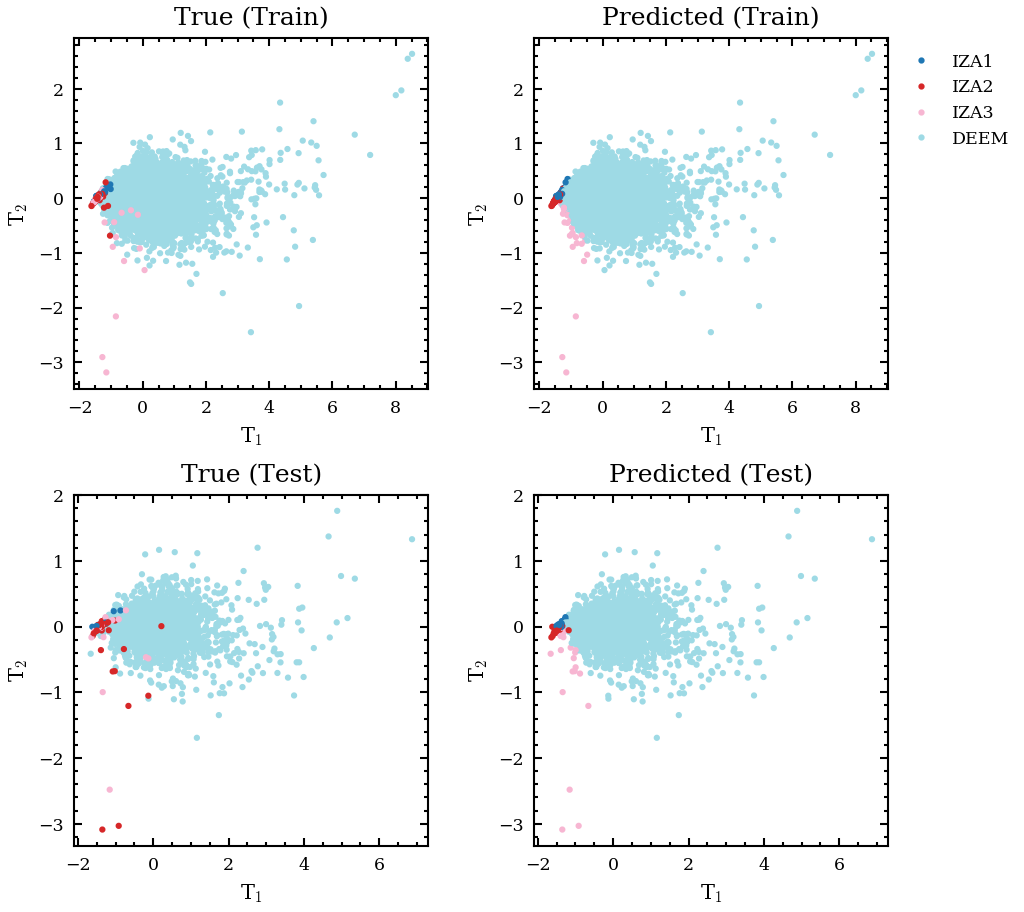

===== 3.5 | 4-Class | Power | OSi =====


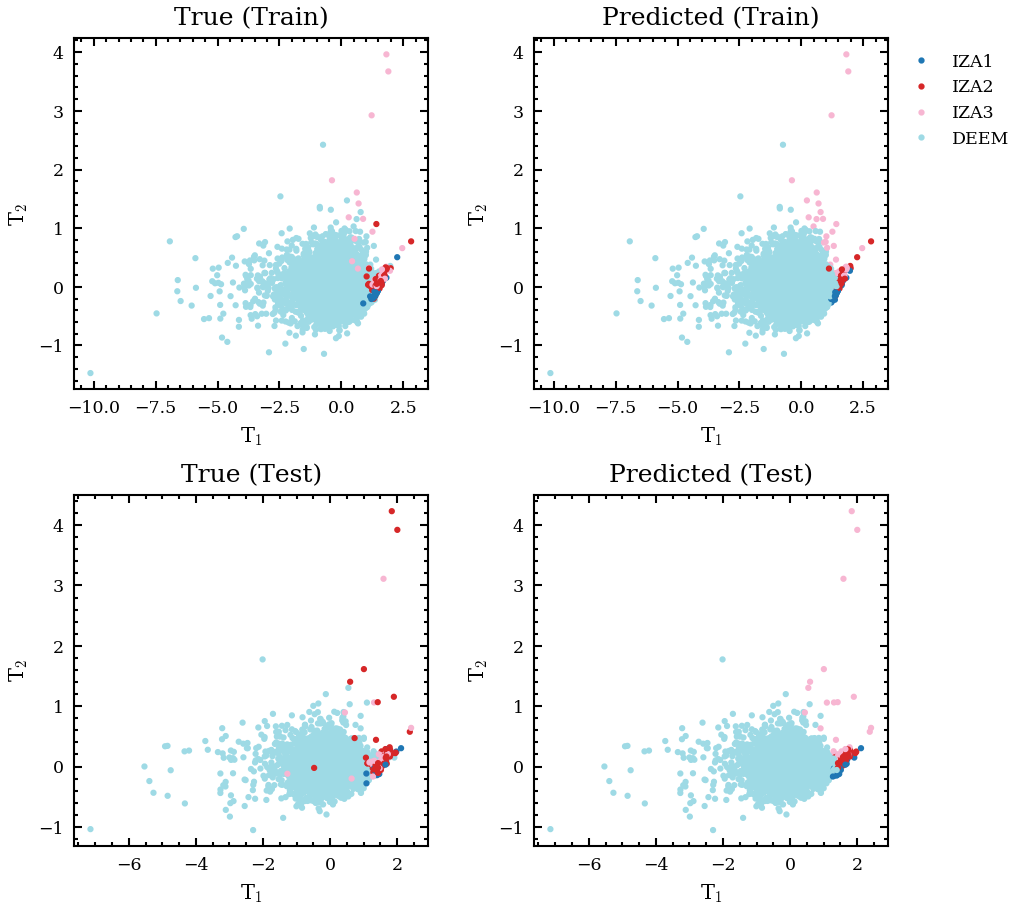

===== 3.5 | 4-Class | Power | SiSi =====


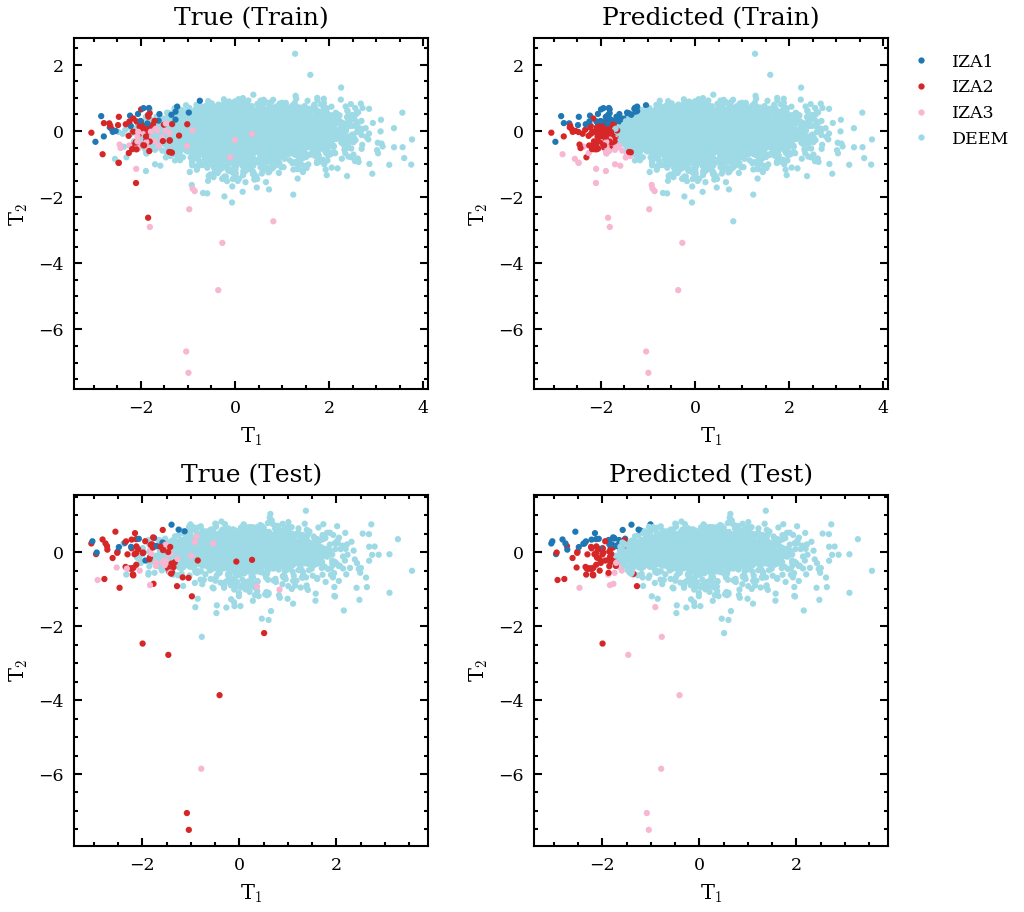

===== 3.5 | 4-Class | Power | OO+OSi =====


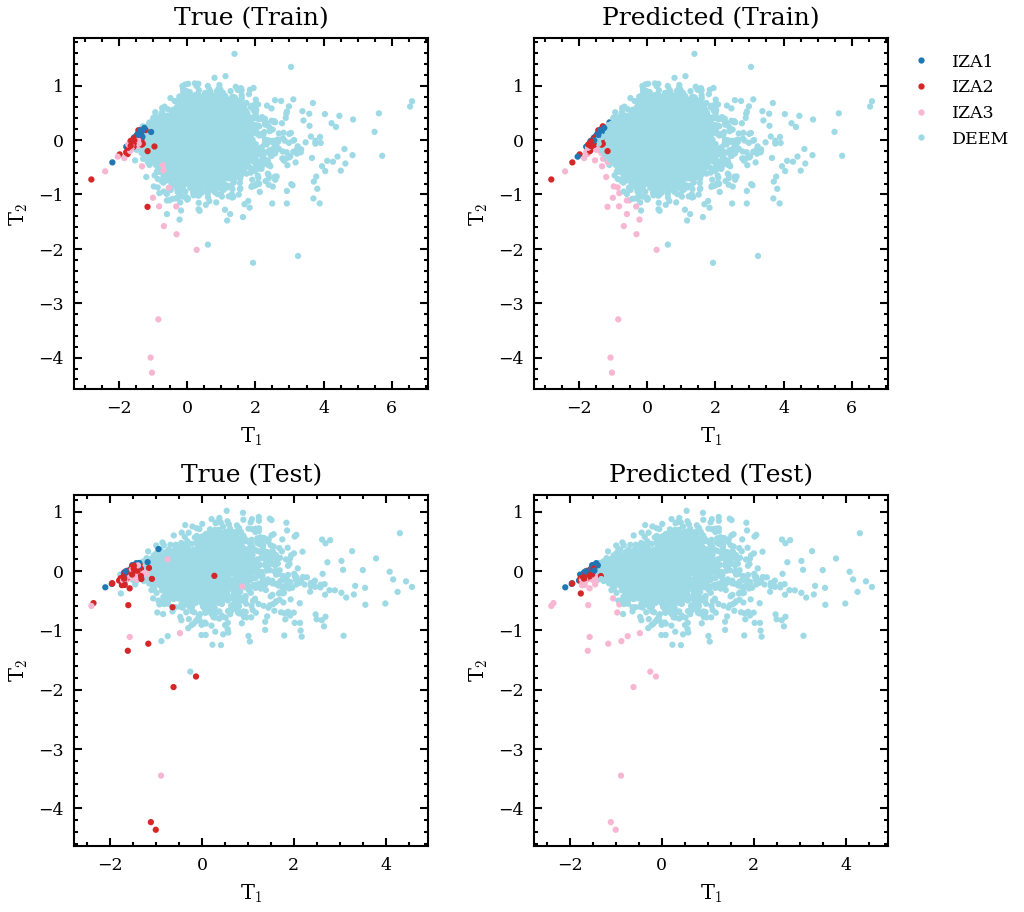

===== 3.5 | 4-Class | Power | OO+SiSi =====


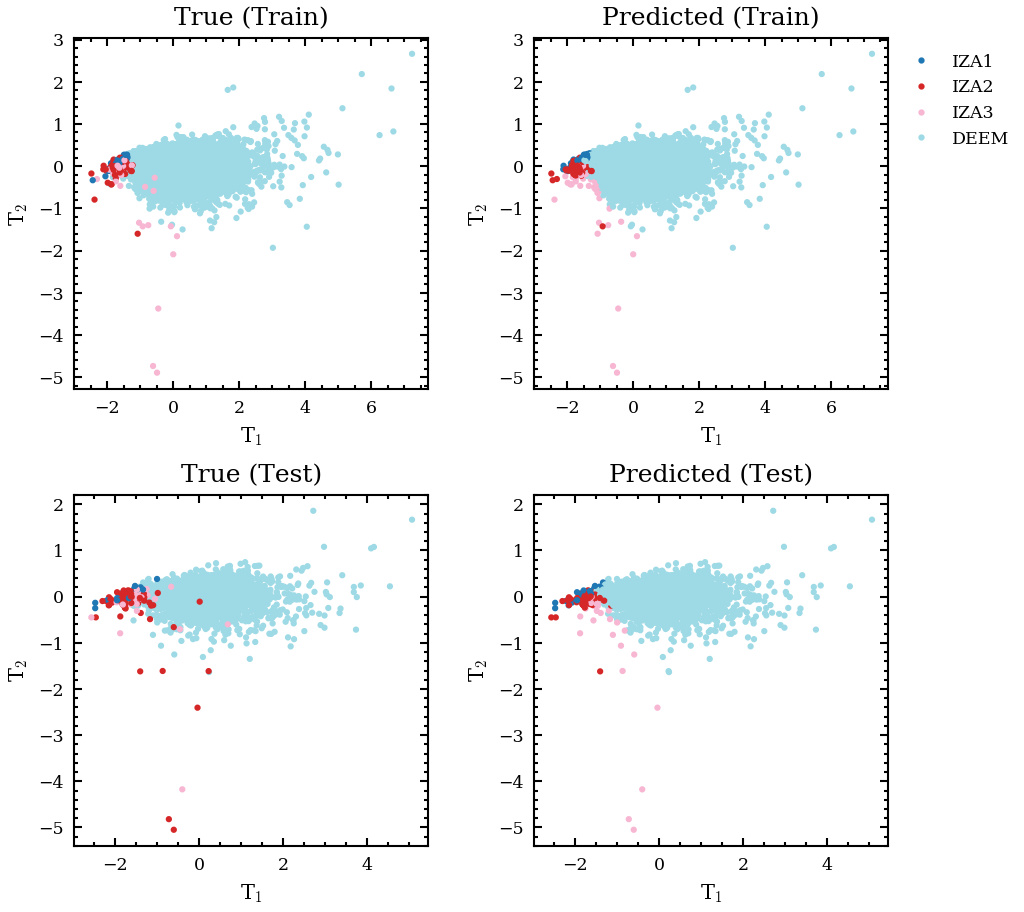

===== 3.5 | 4-Class | Power | OSi+SiSi =====


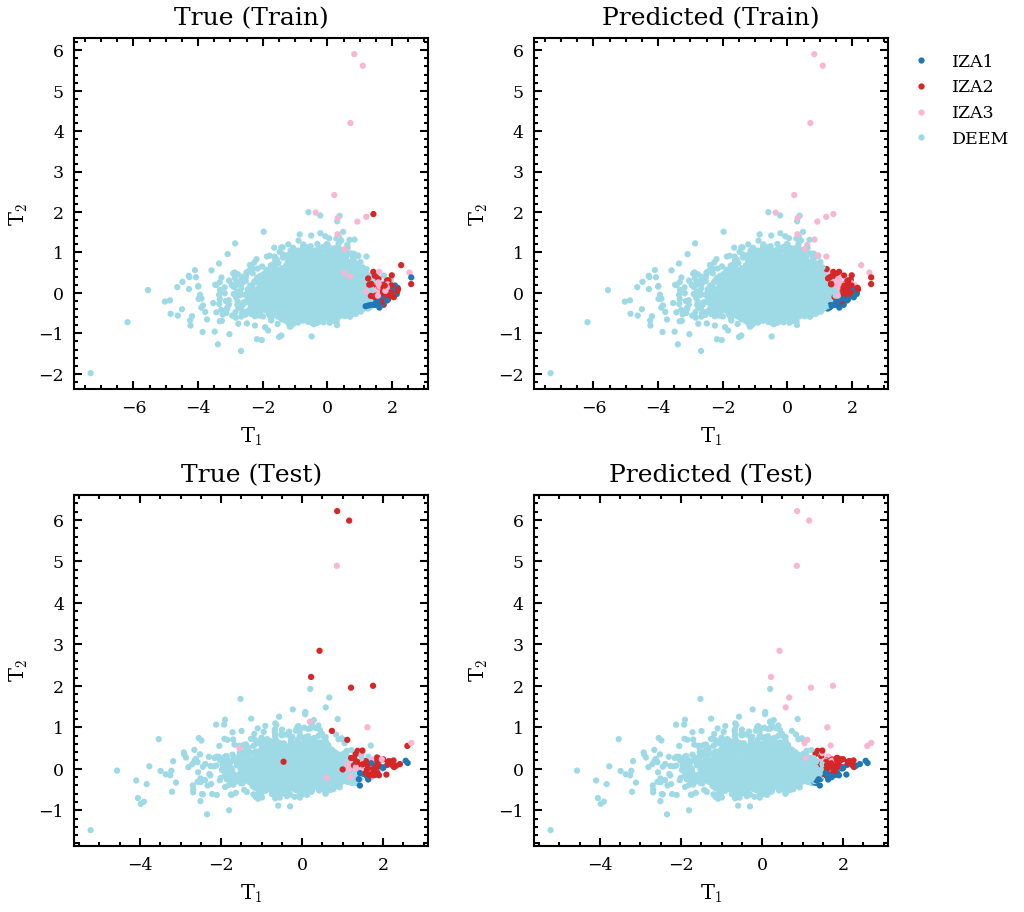

===== 3.5 | 4-Class | Power | OO+OSi+SiSi =====


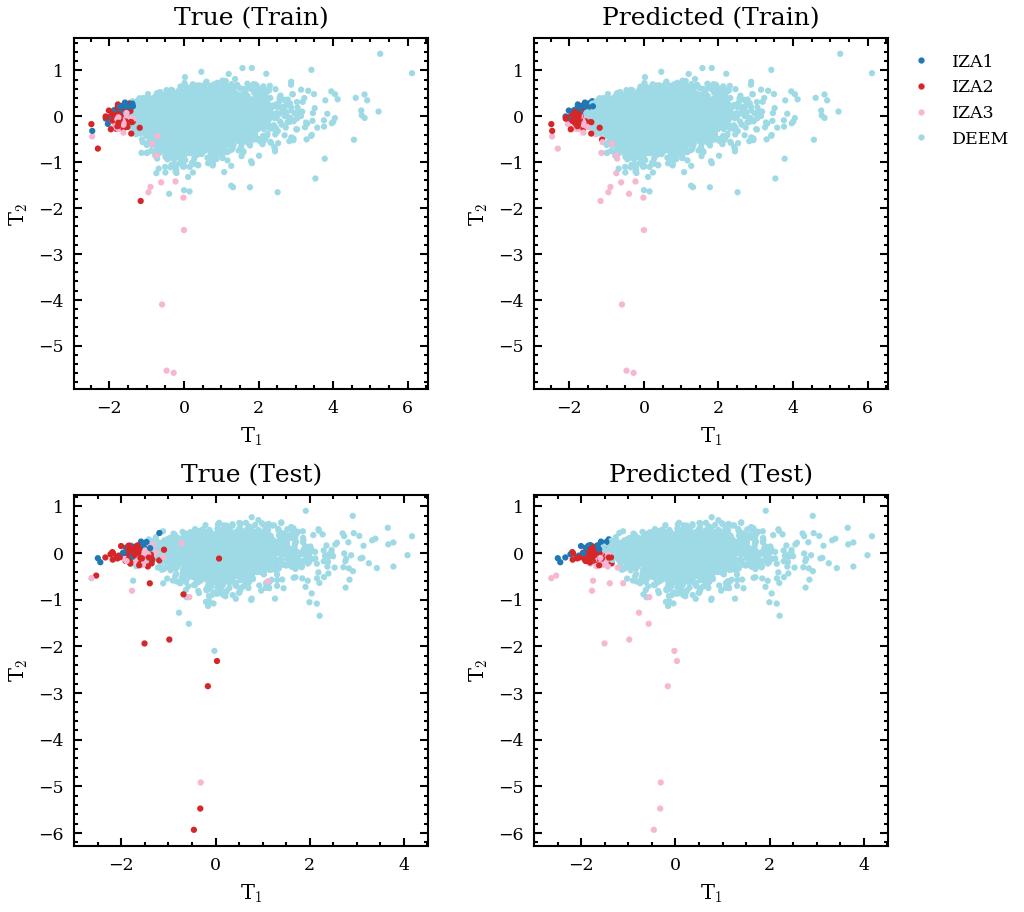

===== 3.5 | 4-Class | Radial | O =====


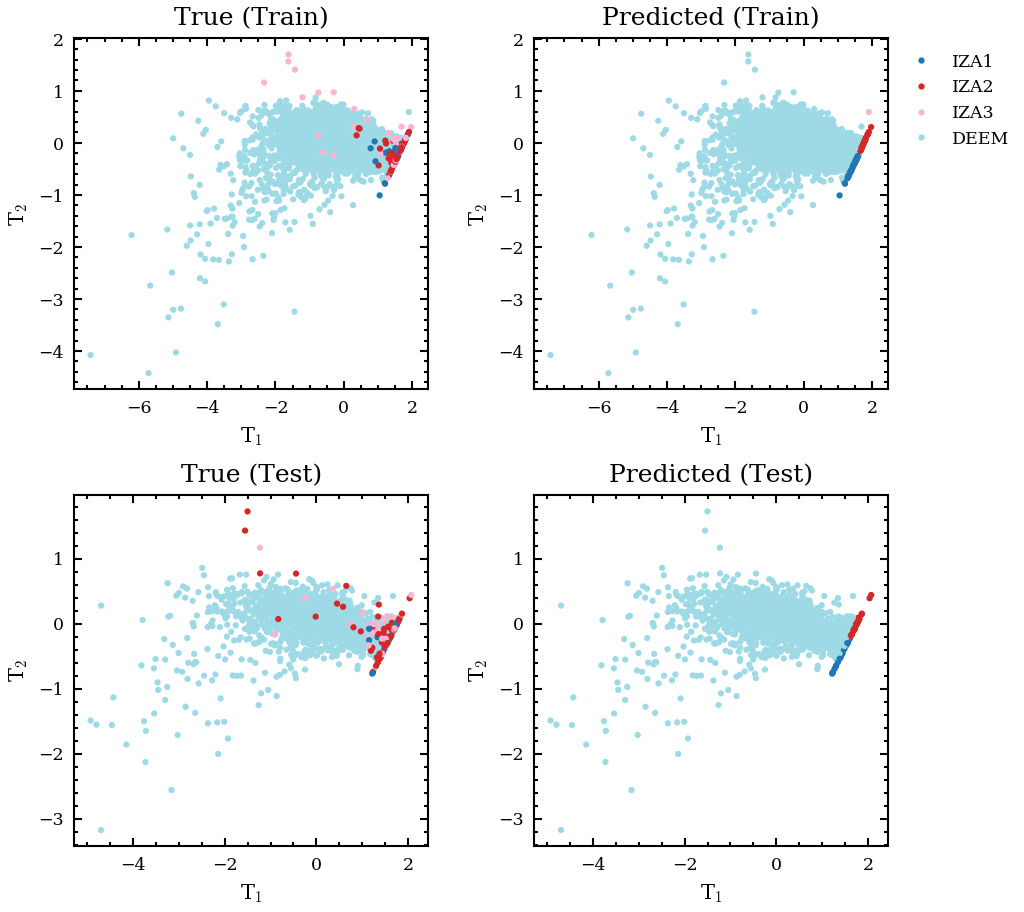

===== 3.5 | 4-Class | Radial | Si =====


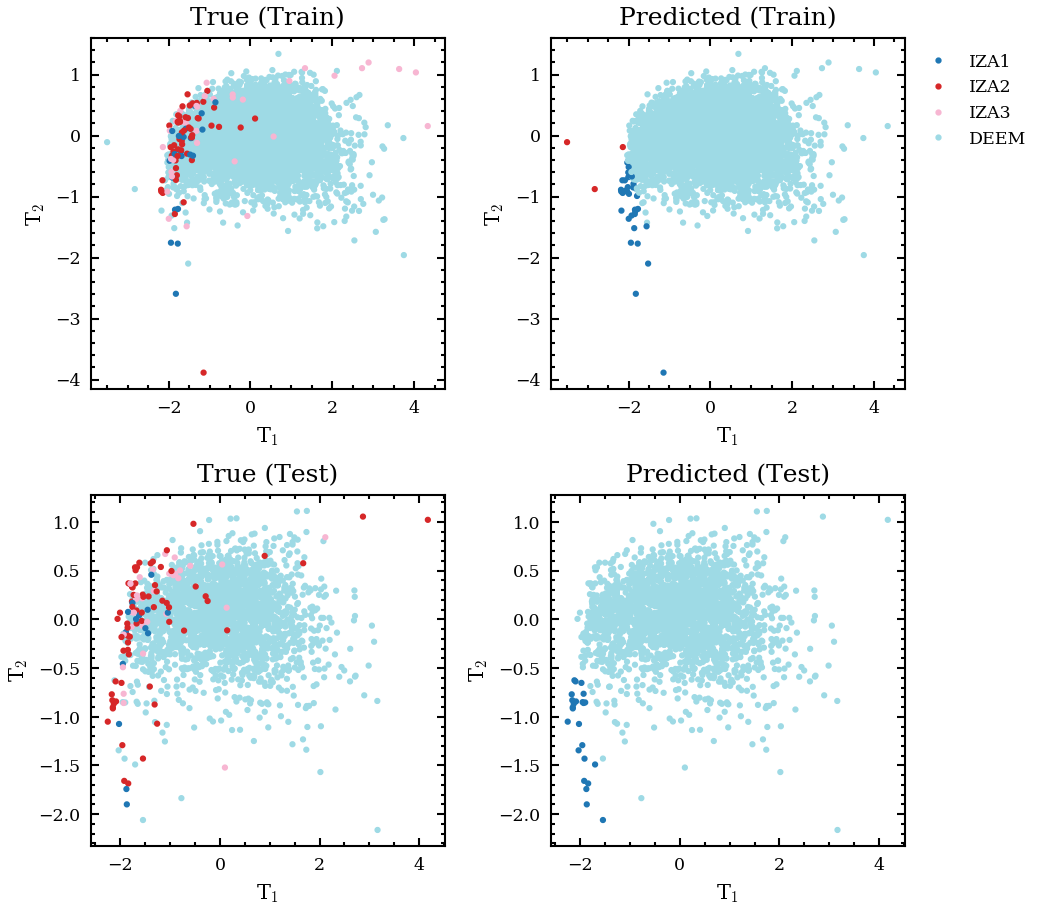

===== 3.5 | 4-Class | Radial | O+Si =====


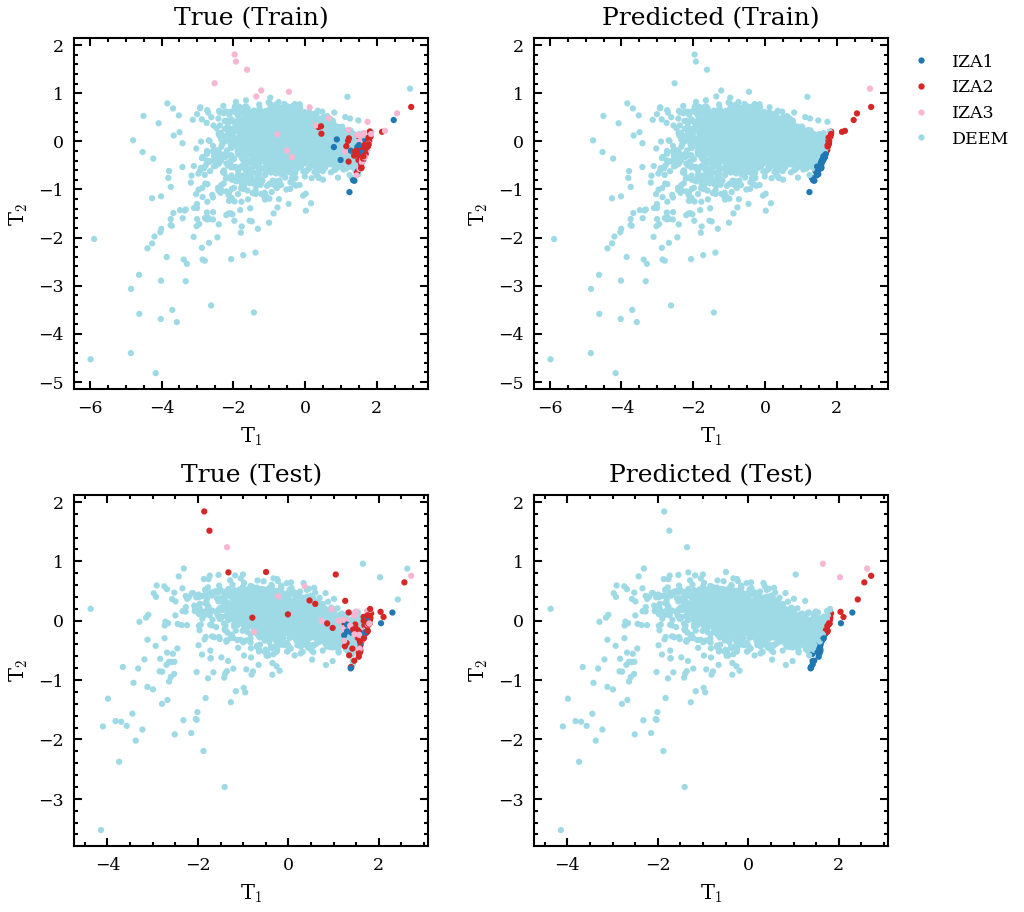

===== 6.0 | 4-Class | Power | OO =====


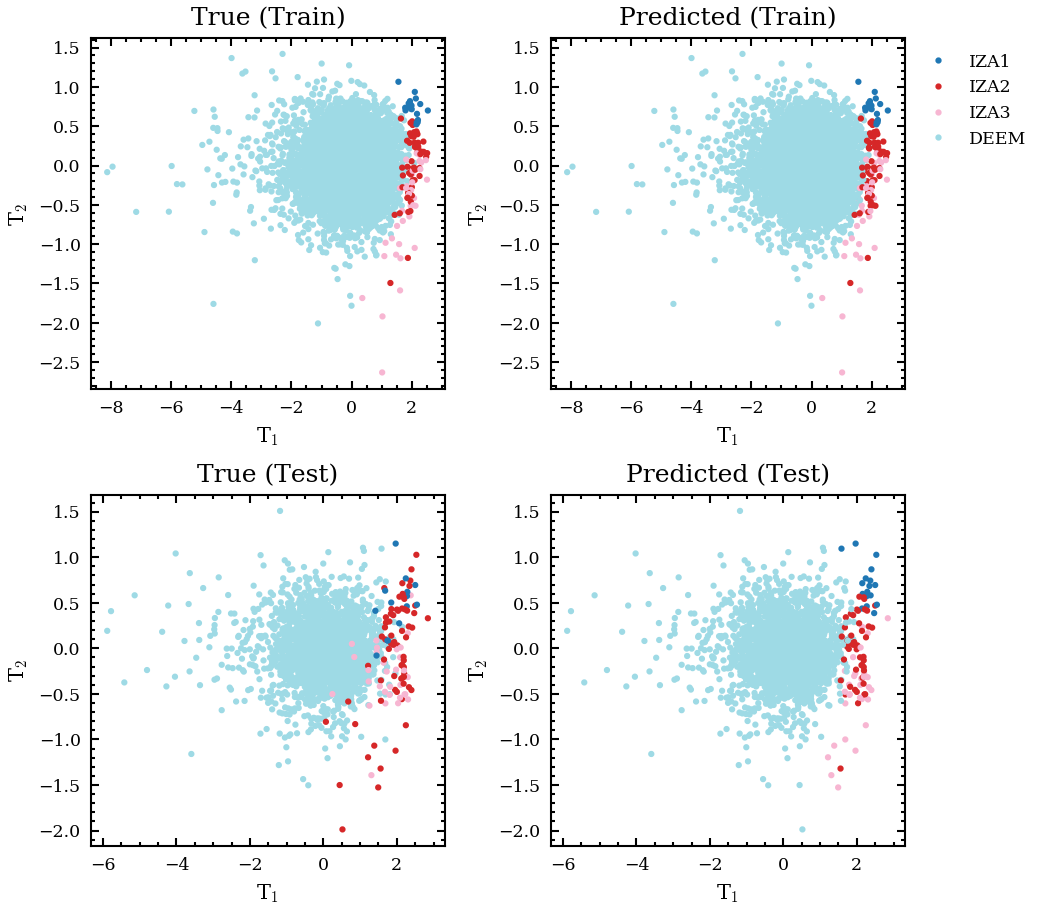

===== 6.0 | 4-Class | Power | OSi =====


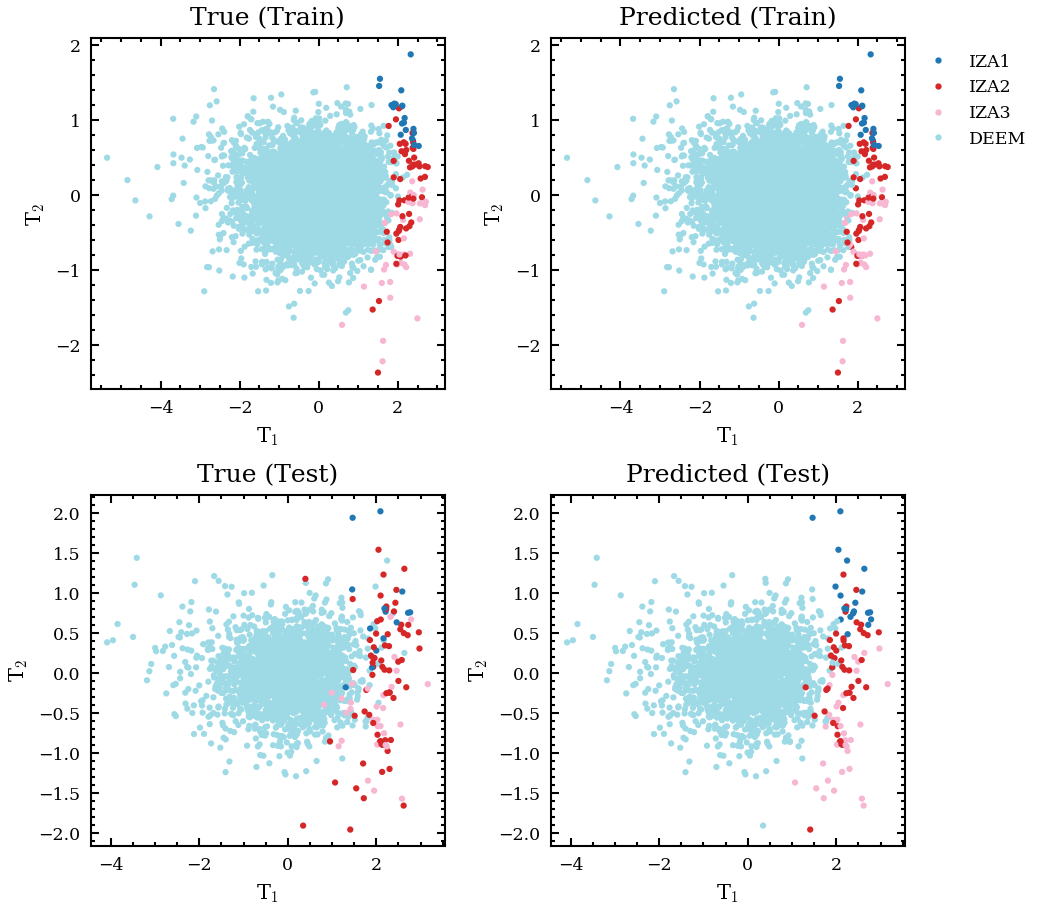

===== 6.0 | 4-Class | Power | SiSi =====


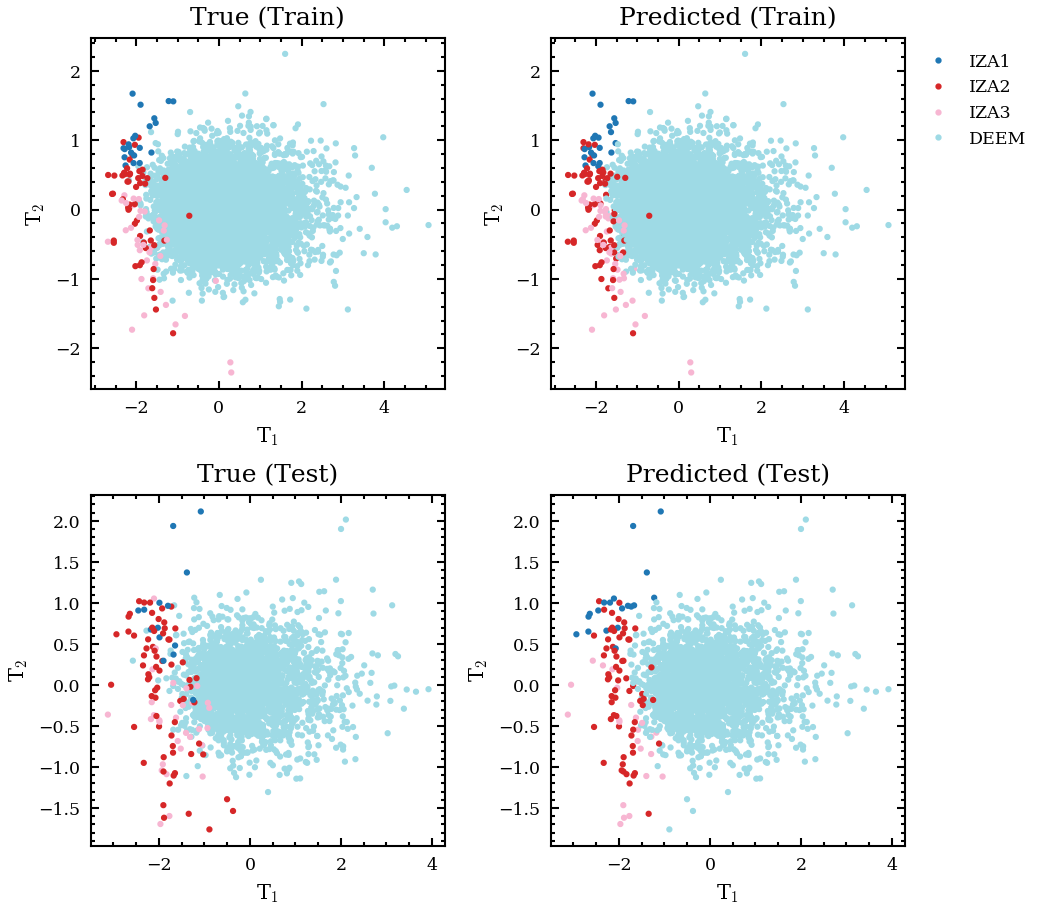

===== 6.0 | 4-Class | Power | OO+OSi =====


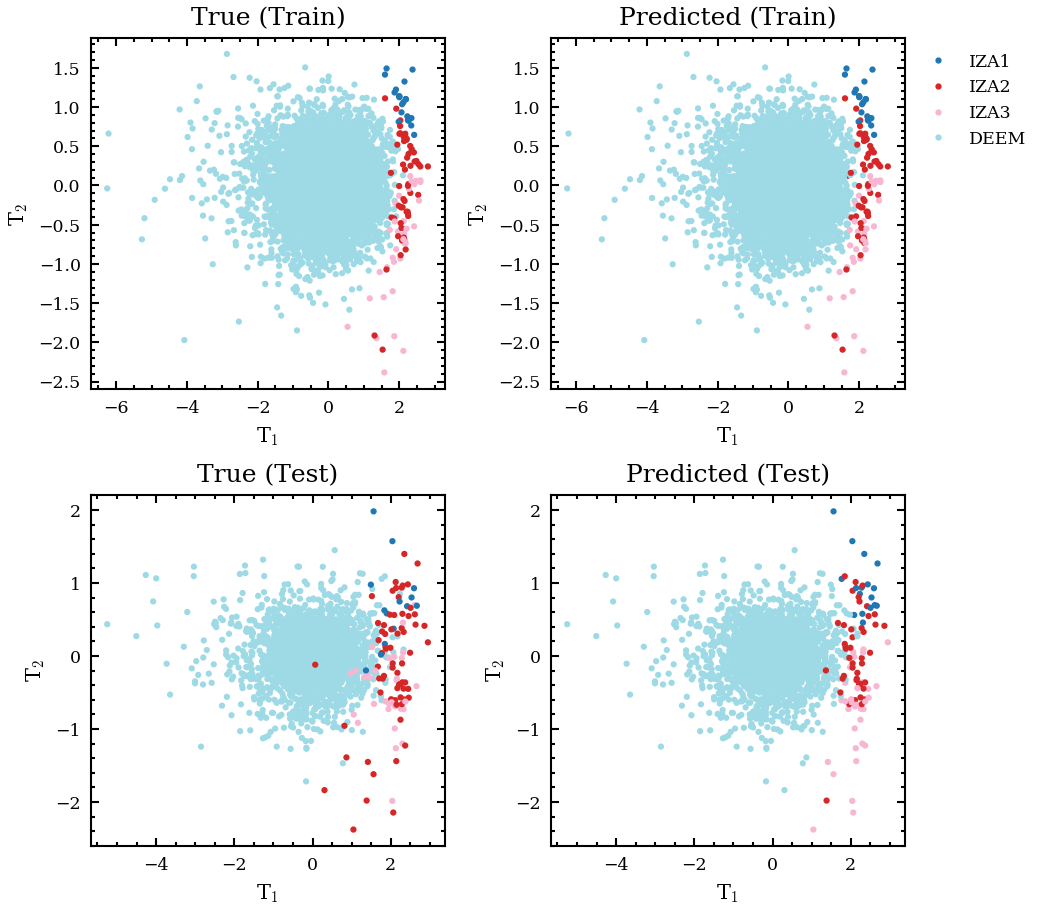

===== 6.0 | 4-Class | Power | OO+SiSi =====


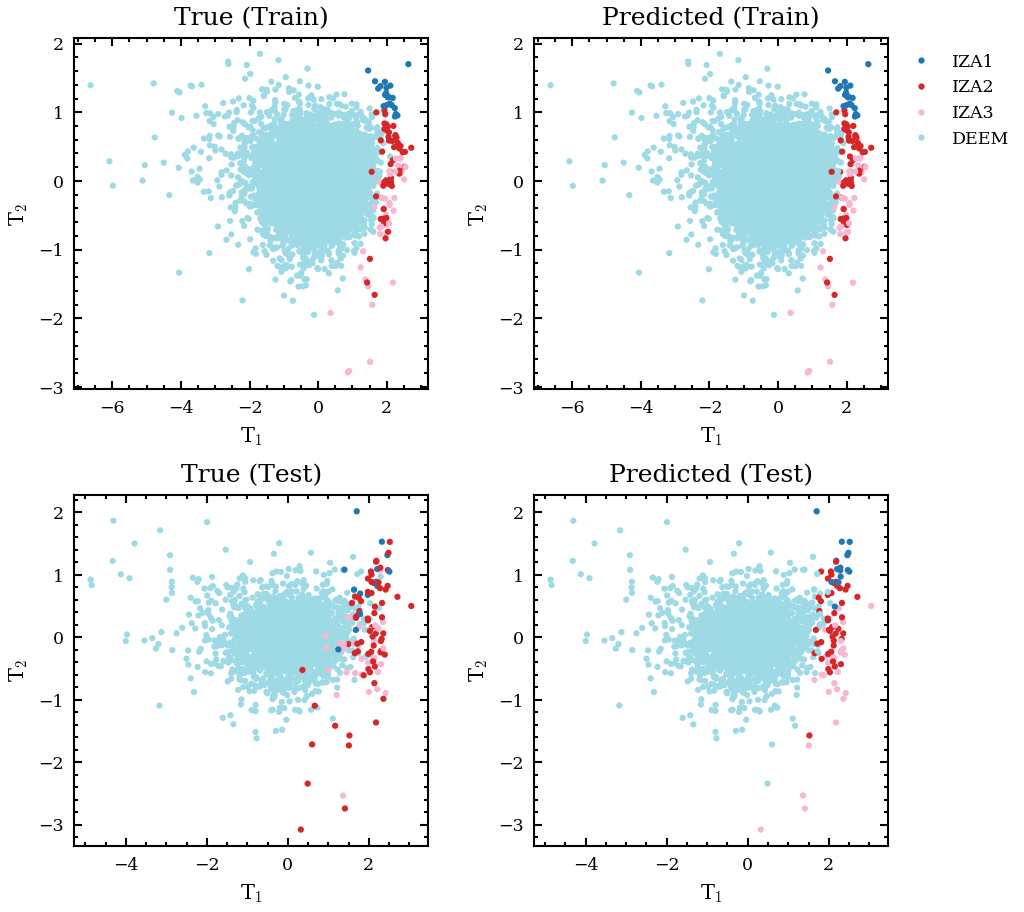

===== 6.0 | 4-Class | Power | OSi+SiSi =====


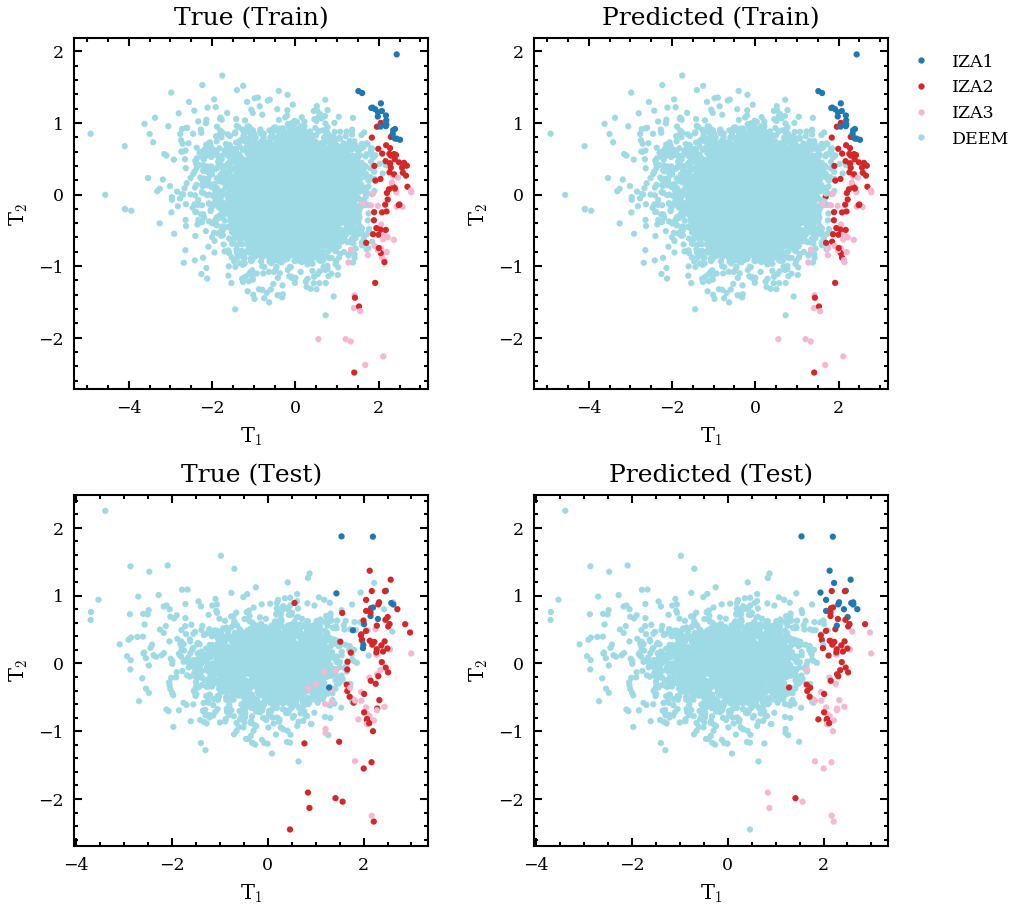

===== 6.0 | 4-Class | Power | OO+OSi+SiSi =====


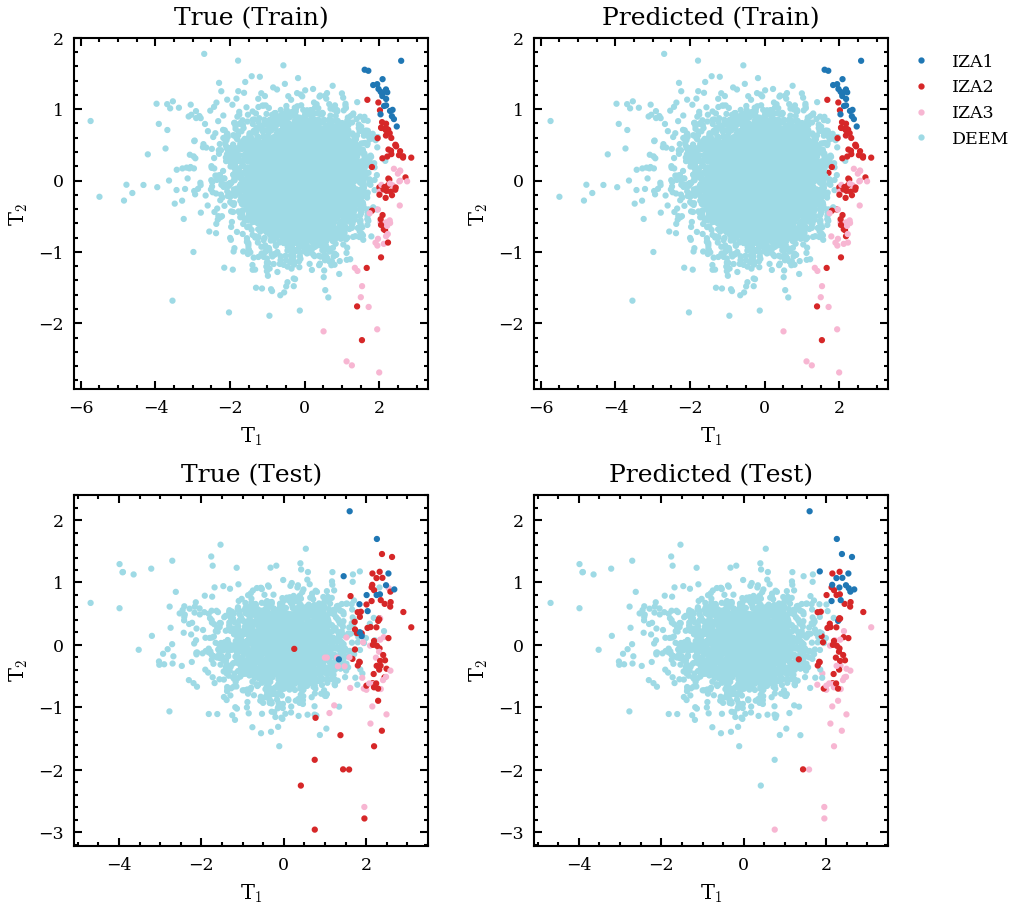

===== 6.0 | 4-Class | Radial | O =====


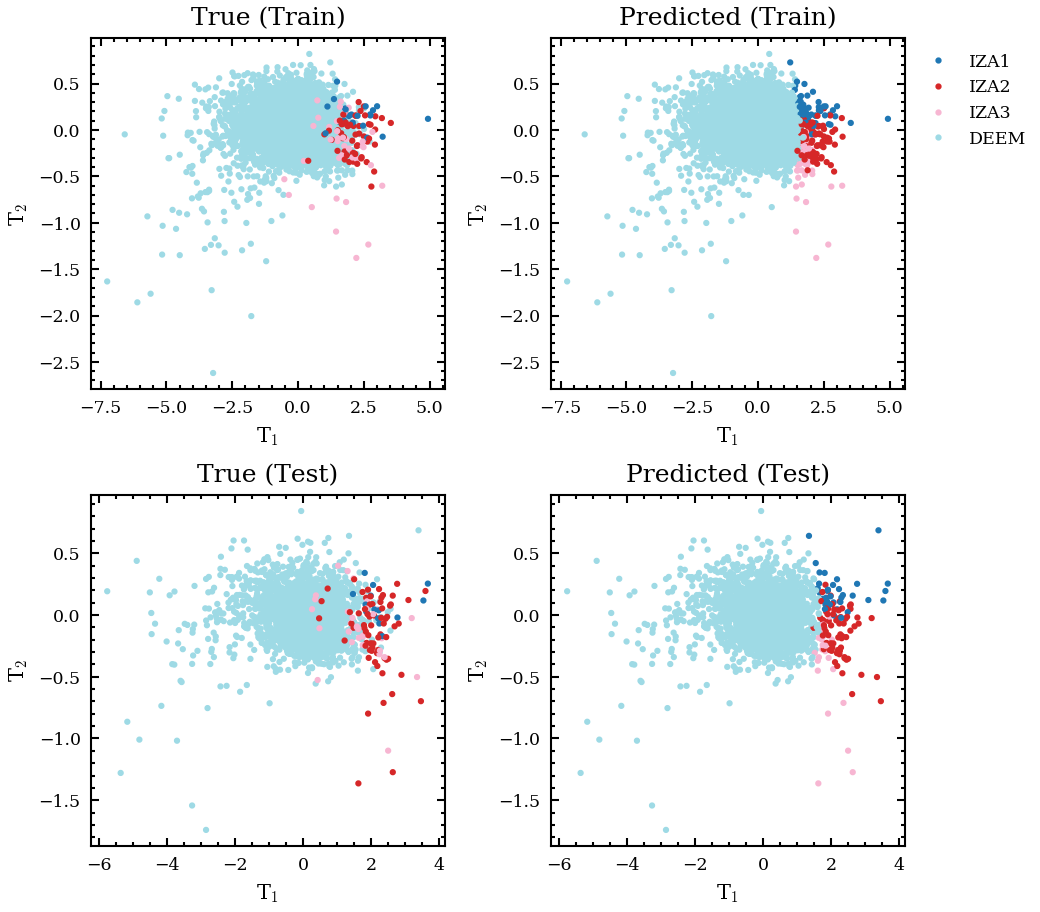

===== 6.0 | 4-Class | Radial | Si =====


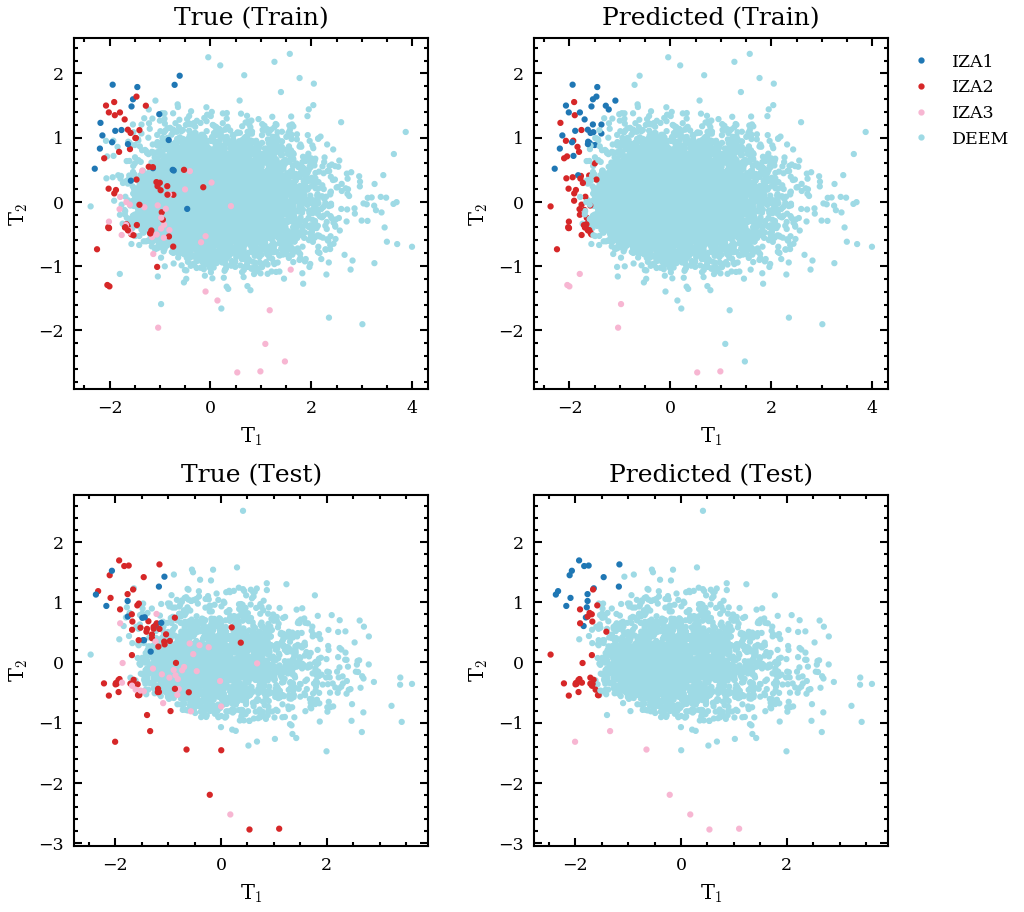

===== 6.0 | 4-Class | Radial | O+Si =====


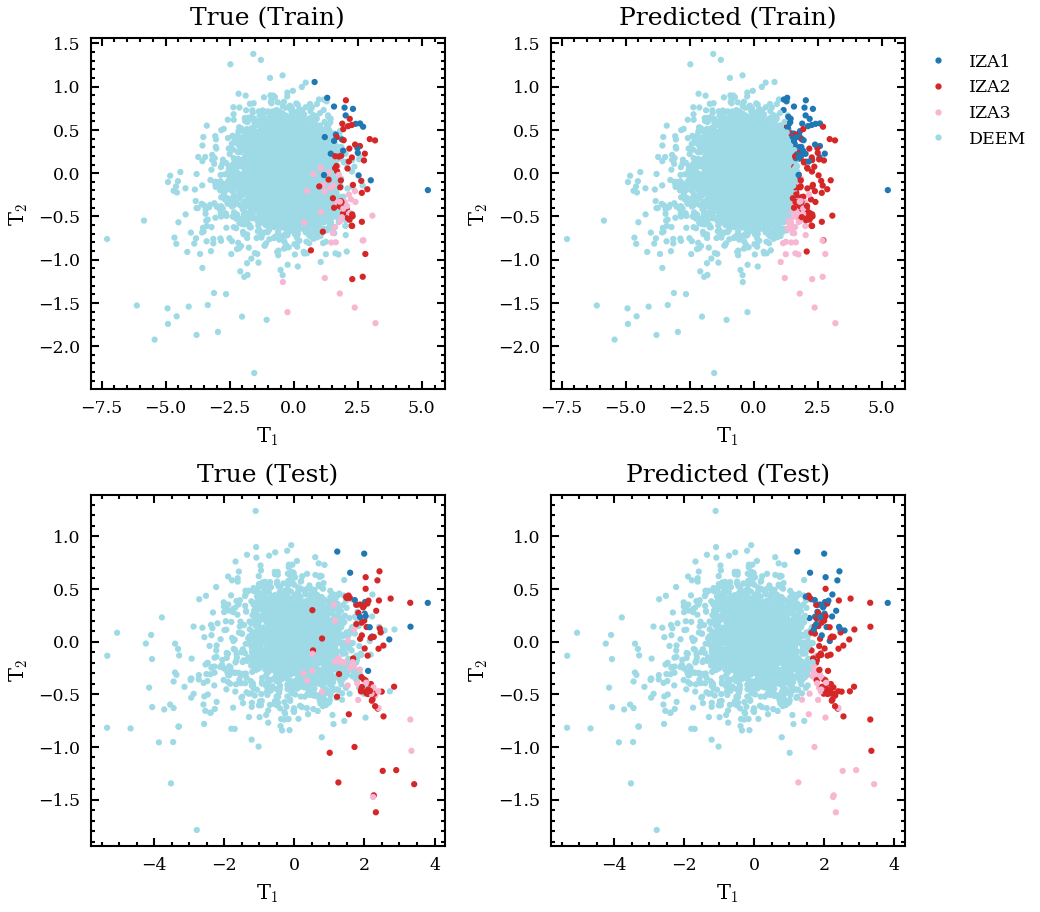

In [30]:
for cutoff in cutoffs:
    for spectrum_type in ('power', 'radial'):
        spectrum_name = spectrum_type.capitalize()
        
        for species_pairing in group_names[spectrum_type]:

            for n_cantons in [4]: #(2, 4):
                
                # Prepare outputs
                data_dir = f'Linear_Models/LSVC-LPCovR/{n_cantons}-Class/{spectrum_name}/{species_pairing}'
            
                print(f'===== {cutoff} | {n_cantons}-Class | {spectrum_name} | {species_pairing} =====')
    
                # Load projections
                deem_file = f'{deem_dir}/{cutoff}/{data_dir}/pcovr_structures.hdf5'
                T_deem = utils.load_structures_from_hdf5(deem_file, datasets=None, concatenate=True)

                iza_file = f'{iza_dir}/{cutoff}/{data_dir}/pcovr_structures.hdf5'
                T_iza = utils.load_structures_from_hdf5(iza_file, datasets=None, concatenate=True)

                # Load predicted cantons
                deem_file = f'{deem_dir}/{cutoff}/{data_dir}/pcovr_structure_cantons.dat'
                predicted_cantons_deem = np.loadtxt(deem_file, dtype=int)

                iza_file = f'{iza_dir}/{cutoff}/{data_dir}/pcovr_structure_cantons.dat'
                predicted_cantons_iza = np.loadtxt(iza_file, dtype=int)

                fig = plt.figure(figsize=(7.0, 7.0))
                axs_true_train = fig.add_subplot(2, 2, 1)
                axs_predicted_train = fig.add_subplot(2, 2, 2)
                axs_true_test = fig.add_subplot(2, 2, 3)
                axs_predicted_test = fig.add_subplot(2, 2, 4)
                scatter_opts = dict(cmap='tab20', vmin=1, vmax=4)
                df_idx = 0

                axs_true_train.scatter(T_deem[idxs_deem_train, 0], T_deem[idxs_deem_train, 1], 
                            c=cantons_deem[idxs_deem_train], zorder=2, **scatter_opts)
                axs_true_train.scatter(T_iza[idxs_iza_train, 0], T_iza[idxs_iza_train, 1], 
                            c=cantons_iza[idxs_iza_train], zorder=3, **scatter_opts)

                axs_predicted_train.scatter(T_deem[idxs_deem_train, 0], T_deem[idxs_deem_train, 1], 
                            #c=df_deem_train[:, df_idx])
                            c=predicted_cantons_deem[idxs_deem_train], zorder=2, **scatter_opts)
                axs_predicted_train.scatter(T_iza[idxs_iza_train, 0], T_iza[idxs_iza_train, 1], 
                            #c=df_iza_train[:, df_idx])
                            c=predicted_cantons_iza[idxs_iza_train], zorder=3, **scatter_opts)

                axs_true_test.scatter(T_deem[idxs_deem_test, 0], T_deem[idxs_deem_test, 1],
                        c=cantons_deem[idxs_deem_test], zorder=2, **scatter_opts)
                axs_true_test.scatter(T_iza[idxs_iza_test, 0], T_iza[idxs_iza_test, 1],
                        c=cantons_iza[idxs_iza_test], zorder=3, **scatter_opts)

                axs_predicted_test.scatter(T_deem[idxs_deem_test, 0], T_deem[idxs_deem_test, 1],
                        #c=df_deem_test[:, df_idx])
                        c=predicted_cantons_deem[idxs_deem_test], zorder=2, **scatter_opts)
                axs_predicted_test.scatter(T_iza[idxs_iza_test, 0], T_iza[idxs_iza_test, 1],
                        #c=df_iza_test[:, df_idx])
                        c=predicted_cantons_iza[idxs_iza_test], zorder=3, **scatter_opts)

                handles = [Line2D([0], [0], c=plt.get_cmap('tab20')(0.0), marker='o', linewidth=0),
                           Line2D([0], [0], c=plt.get_cmap('tab20')(0.33), marker='o', linewidth=0),
                           Line2D([0], [0], c=plt.get_cmap('tab20')(0.67), marker='o', linewidth=0),
                           Line2D([0], [0], c=plt.get_cmap('tab20')(1.0), marker='o', linewidth=0)]

                labels = ['IZA1', 'IZA2', 'IZA3', 'DEEM']
                axs_predicted_train.legend(handles=handles, labels=labels, 
                                           loc='upper left', bbox_to_anchor=(1.0, 1.0))

                for ax in (axs_true_train, axs_predicted_train, axs_true_test, axs_predicted_test):
                    ax.set_xlabel(r'T$_1$')
                    ax.set_ylabel(r'T$_2$')

                axs_true_train.set_title('True (Train)')
                axs_predicted_train.set_title('Predicted (Train)')
                axs_true_test.set_title('True (Test)')
                axs_predicted_test.set_title('Predicted (Test)')

                fig.subplots_adjust(wspace=0.3, hspace=0.3)

                # TODO: change file path
                #fig.savefig(f'../Results/{cutoff}/svm-kpcovr.png', bbox_inches='tight')

                plt.show()

## Classification statistics

### LinearSVC

In [31]:
for cutoff in cutoffs:
    for spectrum_type in ('power', 'radial'):
        spectrum_name = spectrum_type.capitalize()
        
        for species_pairing in group_names[spectrum_type]:

            for n_cantons in (2, 4):
                
                # Prepare outputs
                data_dir = f'Linear_Models/LSVC-LPCovR/{n_cantons}-Class/{spectrum_name}/{species_pairing}'
            
                print(f'===== {cutoff} | {n_cantons}-Class | {spectrum_name} | {species_pairing} =====')

                predicted_cantons_iza = \
                    np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int)
                predicted_cantons_deem = \
                    np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int)

                predicted_cantons_train = np.concatenate((predicted_cantons_iza[idxs_iza_train],
                                                          predicted_cantons_deem[idxs_deem_train]))
                predicted_cantons_test = np.concatenate((predicted_cantons_iza[idxs_iza_test],
                                                         predicted_cantons_deem[idxs_deem_test]))

                matrix_train = confusion_matrix(cantons_train[n_cantons], predicted_cantons_train)
                matrix_test = confusion_matrix(cantons_test[n_cantons], predicted_cantons_test)

                print('----- Train -----')
                print(classification_report(cantons_train[n_cantons], predicted_cantons_train,
                                            zero_division=0))
                print('Train accuracy:', np.sum(np.diag(matrix_train)) / np.sum(matrix_train))
                print()
                print(matrix_train)
                print()

                print('----- Test -----')
                print(classification_report(cantons_test[n_cantons], predicted_cantons_test,
                                            zero_division=0))
                print('Test accuracy:', np.sum(np.diag(matrix_test)) / np.sum(matrix_test))
                print()
                print(matrix_test)
                print()

===== 3.5 | 2-Class | Power | OO =====
----- Train -----
              precision    recall  f1-score   support

           1       0.12      0.97      0.21       112
           2       1.00      0.90      0.95      7750

    accuracy                           0.90      7862
   macro avg       0.56      0.93      0.58      7862
weighted avg       0.99      0.90      0.93      7862

Train accuracy: 0.8978631391503434

[[ 109    3]
 [ 800 6950]]

----- Test -----
              precision    recall  f1-score   support

           1       0.29      0.91      0.44       113
           2       1.00      0.89      0.94      2250

    accuracy                           0.89      2363
   macro avg       0.64      0.90      0.69      2363
weighted avg       0.96      0.89      0.91      2363

Test accuracy: 0.8895471857807872

[[ 103   10]
 [ 251 1999]]

===== 3.5 | 4-Class | Power | OO =====
----- Train -----
              precision    recall  f1-score   support

           1       0.05      0.33

----- Train -----
              precision    recall  f1-score   support

           1       0.18      0.99      0.31       112
           2       1.00      0.93      0.97      7750

    accuracy                           0.94      7862
   macro avg       0.59      0.96      0.64      7862
weighted avg       0.99      0.94      0.96      7862

Train accuracy: 0.9357669804121089

[[ 111    1]
 [ 504 7246]]

----- Test -----
              precision    recall  f1-score   support

           1       0.39      0.89      0.54       113
           2       0.99      0.93      0.96      2250

    accuracy                           0.93      2363
   macro avg       0.69      0.91      0.75      2363
weighted avg       0.97      0.93      0.94      2363

Test accuracy: 0.9280575539568345

[[ 101   12]
 [ 158 2092]]

===== 3.5 | 4-Class | Power | OO+SiSi =====
----- Train -----
              precision    recall  f1-score   support

           1       0.34      0.62      0.44        21
           2 

/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----- Train -----
              precision    recall  f1-score   support

           1       0.04      0.85      0.08       112
           2       1.00      0.73      0.84      7750

    accuracy                           0.73      7862
   macro avg       0.52      0.79      0.46      7862
weighted avg       0.98      0.73      0.83      7862

Train accuracy: 0.7330195878911219

[[  95   17]
 [2082 5668]]

----- Test -----
              precision    recall  f1-score   support

           1       0.14      0.89      0.25       113
           2       0.99      0.73      0.84      2250

    accuracy                           0.74      2363
   macro avg       0.57      0.81      0.54      2363
weighted avg       0.95      0.74      0.81      2363

Test accuracy: 0.739737621667372

[[ 101   12]
 [ 603 1647]]

===== 3.5 | 4-Class | Radial | Si =====
----- Train -----
              precision    recall  f1-score   support

           1       0.15      0.24      0.19        21
           2      

----- Train -----
              precision    recall  f1-score   support

           1       0.46      1.00      0.63       112
           2       1.00      0.98      0.99      7750

    accuracy                           0.98      7862
   macro avg       0.73      0.99      0.81      7862
weighted avg       0.99      0.98      0.99      7862

Train accuracy: 0.9834647672348003

[[ 112    0]
 [ 130 7620]]

----- Test -----
              precision    recall  f1-score   support

           1       0.66      0.85      0.74       113
           2       0.99      0.98      0.99      2250

    accuracy                           0.97      2363
   macro avg       0.83      0.91      0.86      2363
weighted avg       0.98      0.97      0.97      2363

Test accuracy: 0.9720694033008886

[[  96   17]
 [  49 2201]]

===== 6.0 | 4-Class | Power | SiSi =====
----- Train -----
              precision    recall  f1-score   support

           1       0.83      0.90      0.86        21
           2    

----- Train -----
              precision    recall  f1-score   support

           1       0.97      1.00      0.99       112
           2       1.00      1.00      1.00      7750

    accuracy                           1.00      7862
   macro avg       0.99      1.00      0.99      7862
weighted avg       1.00      1.00      1.00      7862

Train accuracy: 0.9996184177054185

[[ 112    0]
 [   3 7747]]

----- Test -----
              precision    recall  f1-score   support

           1       0.87      0.76      0.81       113
           2       0.99      0.99      0.99      2250

    accuracy                           0.98      2363
   macro avg       0.93      0.88      0.90      2363
weighted avg       0.98      0.98      0.98      2363

Test accuracy: 0.9830723656369023

[[  86   27]
 [  13 2237]]

===== 6.0 | 4-Class | Power | OO+OSi+SiSi =====
----- Train -----
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        21
         

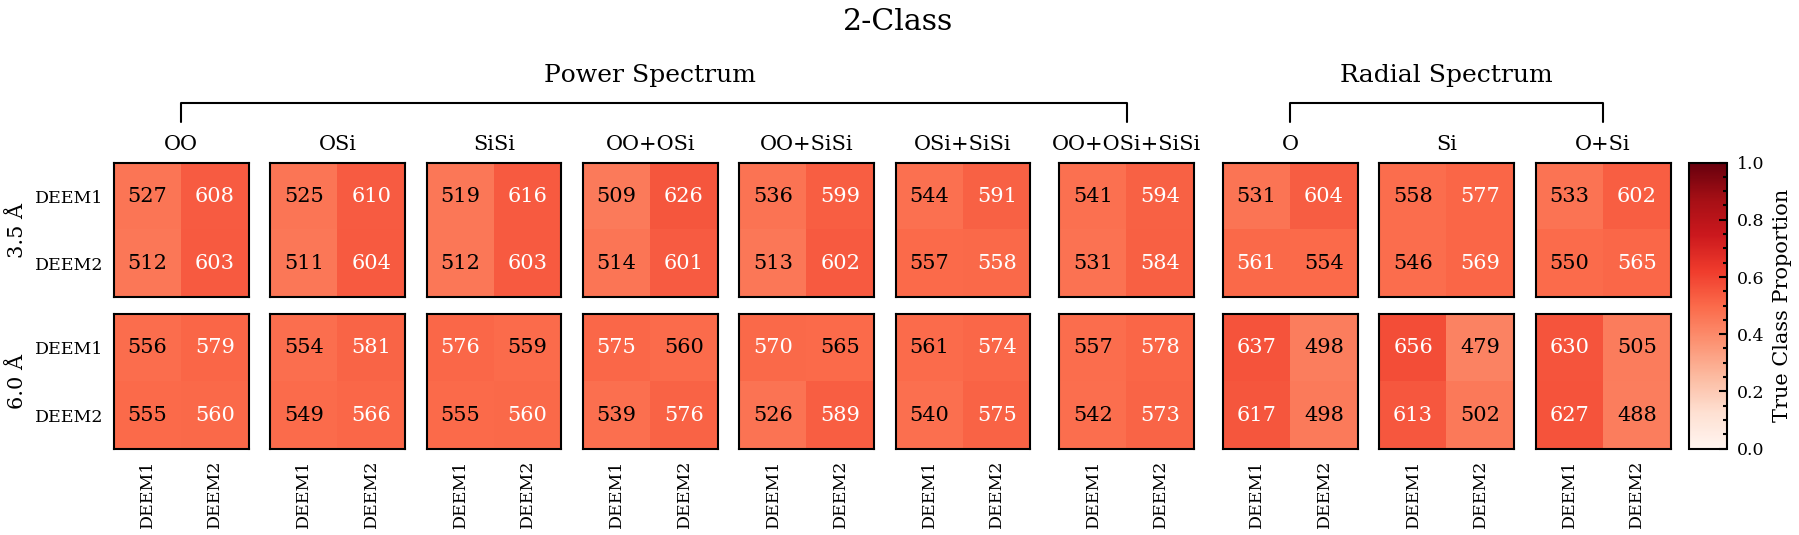

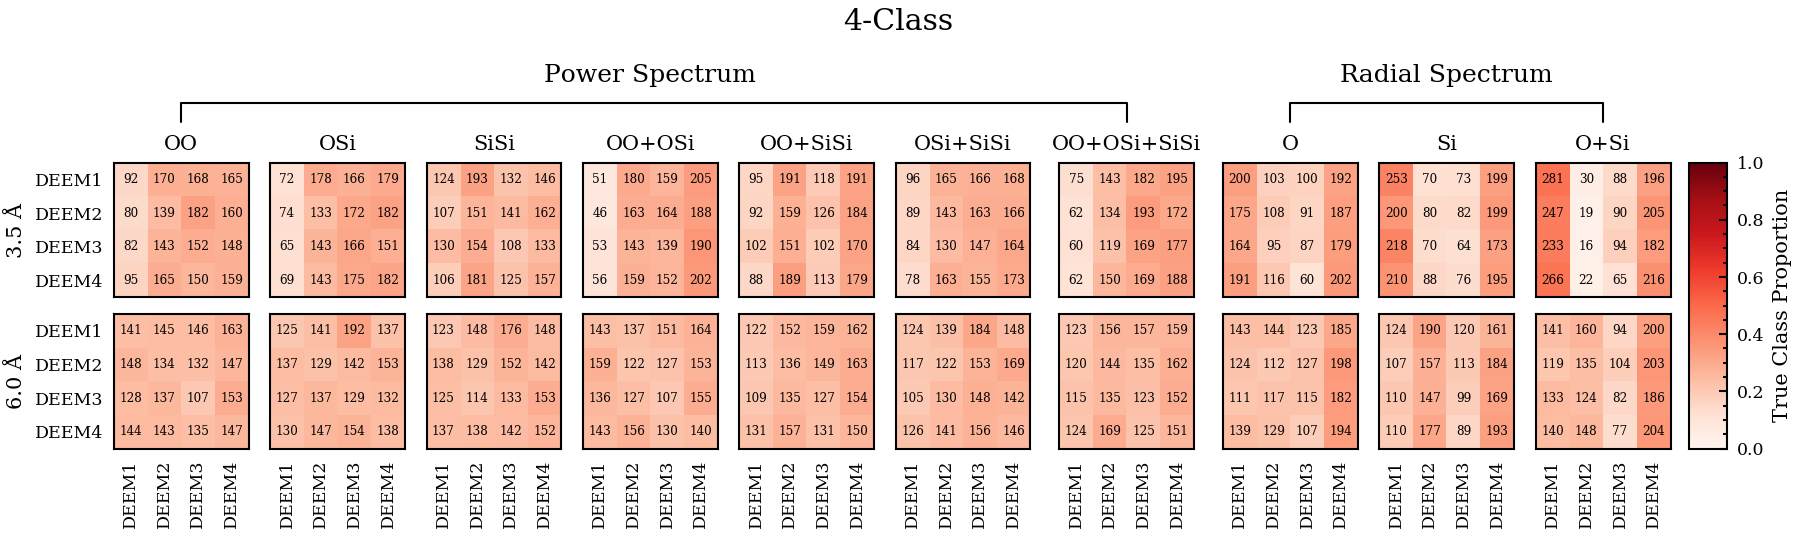

In [32]:
fig_2class = plt.figure(figsize=(12, 2.7), constrained_layout=True)
fig_4class = plt.figure(figsize=(12, 2.7), constrained_layout=True)

n_rows = 2
n_cols = 10

vmin = 0.0 #-len(idxs_iza_test)
vmax = 1.0 #len(idxs_iza_test)

width_ratios = np.ones(n_cols + 1)
width_ratios[-1] = 0.25

for fig, n_cantons in zip((fig_2class, fig_4class), (2, 4)):
    gs = fig.add_gridspec(nrows=n_rows, ncols=n_cols+1, 
                          width_ratios=width_ratios,
                          hspace=0.05, wspace=0.05)
    axes = np.array([[fig.add_subplot(gs[i, j]) for j in range(0, n_cols)] for i in range(0, n_rows)])
    row_idx = 0
    for cutoff in cutoffs:
        col_idx = 0
        for spectrum_type in ('power', 'radial'):
            spectrum_name = spectrum_type.capitalize()

            for species_pairing in group_names[spectrum_type]:

                # Prepare outputs
                data_dir = f'Linear_Models/LSVC-LPCovR/{n_cantons}-Class/{spectrum_name}/{species_pairing}'

#                 predicted_cantons_iza = \
#                     np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int)
#                 predicted_cantons_deem = \
#                     np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int)

#                 predicted_cantons_train = np.concatenate((predicted_cantons_iza[idxs_iza_train],
#                                                           predicted_cantons_deem[idxs_deem_train]))
#                 predicted_cantons_test = np.concatenate((predicted_cantons_iza[idxs_iza_test],
#                                                          predicted_cantons_deem[idxs_deem_test]))

                dummy_cantons = np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/dummy_svc_structure_cantons.dat', dtype=int) ###
                predicted_cantons_train = dummy_cantons[idxs_deem_train] ###
                predicted_cantons_test = dummy_cantons[idxs_deem_test] ###

#                 matrix_train = confusion_matrix(cantons_train[n_cantons], predicted_cantons_train)
#                 matrix_test = confusion_matrix(cantons_test[n_cantons], predicted_cantons_test)

                matrix_train = confusion_matrix(dummy_cantons_deem_train[n_cantons], predicted_cantons_train) ###
                matrix_test = confusion_matrix(dummy_cantons_deem_test[n_cantons], predicted_cantons_test) ###

                matrix_ref = np.zeros((n_cantons, n_cantons), dtype=int)
                for i in range(0, n_cantons):
                    #matrix_ref[i, i] = np.count_nonzero(cantons_test[n_cantons] == (i + 1))
                    matrix_ref[i, i] = np.count_nonzero(dummy_cantons_deem_test[n_cantons] == (i + 1)) ###
                    
                matrix_norm = matrix_test / np.diagonal(matrix_ref)[:, np.newaxis]
                
                ax = axes[row_idx, col_idx]
                ax.imshow(matrix_norm, cmap='Reds', vmin=vmin, vmax=vmax)
                
                if n_cantons == 2:
                    text_size = 'medium'
                else:
                    text_size = 'xx-small'
                
                for i in range(0, n_cantons):
                    for j in range(0, n_cantons):
                        if matrix_norm[i, j] > (0.5 * vmax):
                            text_color = 'w'
                        else:
                            text_color = 'k'
                        ax.text(j, i, f'{matrix_test[i, j]:d}', 
                                horizontalalignment='center', verticalalignment='center',
                                color=text_color, fontsize=text_size)
                                
                ax.set_xticks(np.arange(0, n_cantons))
                ax.set_yticks(np.arange(0, n_cantons))
                
                ax.tick_params(axis='both', which='both', 
                               left=False, bottom=False, right=False, top=False,
                               labelleft=False, labelbottom=False, labelright=False, labeltop=False)
                
                if col_idx == 0:
                    ax.set_ylabel(f'{cutoff} ' + u'\u00c5')
                    ax.set_yticklabels(ticklabels[n_cantons])
                    ax.tick_params(axis='y', which='both', labelleft=True)
                    
                if row_idx == 0:
                    ax.set_title(f'{species_pairing}', fontsize='medium')
                elif row_idx == (n_rows - 1):
                    ax.set_xticklabels(ticklabels[n_cantons], rotation=90)
                    ax.tick_params(axis='x', which='both', labelbottom=True)

                col_idx += 1
        
        row_idx += 1        
    
    cp_xy = (0.5, 1.3)
    cp_power_bar_frac = -0.02
    cp_radial_bar_frac = cp_power_bar_frac * 3
    cp_power = ConnectionPatch(xyA=cp_xy, coordsA=axes[0, 0].transAxes,
                               xyB=cp_xy, coordsB=axes[0, 6].transAxes,
                               connectionstyle=f'bar,fraction={cp_power_bar_frac}')
    cp_radial = ConnectionPatch(xyA=cp_xy, coordsA=axes[0, 7].transAxes,
                                xyB=cp_xy, coordsB=axes[0, 9].transAxes,
                               connectionstyle=f'bar,fraction={cp_radial_bar_frac}')
    
    n_power = len(group_names['power'])
    n_radial = len(group_names['radial'])
    
    power_label_ax = axes[0, n_power // 2]
    if n_power % 2 == 0:
        power_shift = 0.5
    else:
        power_shift = 0.0
        
    radial_label_ax = axes[0, n_radial // 2 + n_power]
    if n_radial % 2 == 0:
        radial_shift = 0.5
    else:
        radial_shift = 0.0
    
    fig.text(0.5 - power_shift, 1.65, 'Power Spectrum',
             horizontalalignment='center', verticalalignment='center',
             transform=power_label_ax.transAxes, fontsize='large')
    
    fig.text(0.5 - radial_shift, 1.65, 'Radial Spectrum',
             horizontalalignment='center', verticalalignment='center',
             transform=radial_label_ax.transAxes, fontsize='large')
    
    cax = fig.add_subplot(gs[:, -1])
    cb = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap='Reds'), 
                      cax=cax)
    cb.set_label('True Class Proportion')
    
    fig.add_artist(cp_power)
    fig.add_artist(cp_radial)
    fig.suptitle(f'{n_cantons}-Class', y=1.3)
    
    #fig.savefig(f'../../Results/svc_confusion_matrices_{n_cantons}-class.pdf', bbox_inches='tight')
    fig.savefig(f'../../Results/dummy_svc_confusion_matrices_{n_cantons}-class.pdf', bbox_inches='tight')
    
plt.show()

### PCovR

In [33]:
for cutoff in cutoffs:
    for spectrum_type in ('power', 'radial'):
        spectrum_name = spectrum_type.capitalize()
        
        for species_pairing in group_names[spectrum_type]:

            for n_cantons in (2, 4):
                
                # Prepare outputs
                data_dir = f'Linear_Models/LSVC-LPCovR/{n_cantons}-Class/{spectrum_name}/{species_pairing}'
            
                print(f'===== {cutoff} | {n_cantons}-Class | {spectrum_name} | {species_pairing} =====')            
                
                predicted_cantons_iza = \
                    np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/pcovr_structure_cantons.dat', dtype=int)
                predicted_cantons_deem = \
                    np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/pcovr_structure_cantons.dat', dtype=int)

                predicted_cantons_train = np.concatenate((predicted_cantons_iza[idxs_iza_train],
                                                          predicted_cantons_deem[idxs_deem_train]))
                predicted_cantons_test = np.concatenate((predicted_cantons_iza[idxs_iza_test],
                                                         predicted_cantons_deem[idxs_deem_test]))

                dfs_svc_iza = np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/svc_structure_dfs.dat')
                dfs_svc_deem = np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/svc_structure_dfs.dat')

                dfs_pcovr_iza = np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/pcovr_structure_dfs.dat')
                dfs_pcovr_deem = np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/pcovr_structure_dfs.dat')

                dfs_svc_train = np.concatenate((dfs_svc_iza[idxs_iza_train],
                                                dfs_svc_deem[idxs_deem_train]))
                dfs_svc_test = np.concatenate((dfs_svc_iza[idxs_iza_test],
                                               dfs_svc_deem[idxs_deem_test]))

                dfs_pcovr_train = np.concatenate((dfs_pcovr_iza[idxs_iza_train],
                                                  dfs_pcovr_deem[idxs_deem_train]))
                dfs_pcovr_test = np.concatenate((dfs_pcovr_iza[idxs_iza_test],
                                                 dfs_pcovr_deem[idxs_deem_test]))

                matrix_train = confusion_matrix(cantons_train[n_cantons], predicted_cantons_train)
                matrix_test = confusion_matrix(cantons_test[n_cantons], predicted_cantons_test)

                print('----- Train -----')
                print(classification_report(cantons_train[n_cantons], predicted_cantons_train,
                                            zero_division=0))
                print('Train accuracy:', np.sum(np.diag(matrix_train)) / np.sum(matrix_train))
                print()
                print(matrix_train)
                print()
                print('Train DF MAE:', MAE(dfs_svc_train, dfs_pcovr_train))
                print()

                print('----- Test -----')
                print(classification_report(cantons_test[n_cantons], predicted_cantons_test,
                                            zero_division=0))
                print('Test accuracy:', np.sum(np.diag(matrix_test)) / np.sum(matrix_test))
                print()
                print(matrix_test)
                print()
                print('Test DF MAE:', MAE(dfs_svc_test, dfs_pcovr_test))
                print()

===== 3.5 | 2-Class | Power | OO =====
----- Train -----
              precision    recall  f1-score   support

           1       0.12      0.97      0.21       112
           2       1.00      0.90      0.95      7750

    accuracy                           0.90      7862
   macro avg       0.56      0.93      0.58      7862
weighted avg       0.99      0.90      0.93      7862

Train accuracy: 0.8978631391503434

[[ 109    3]
 [ 800 6950]]

Train DF MAE: 2.4200714356397857

----- Test -----
              precision    recall  f1-score   support

           1       0.29      0.91      0.44       113
           2       1.00      0.89      0.94      2250

    accuracy                           0.89      2363
   macro avg       0.64      0.90      0.69      2363
weighted avg       0.96      0.89      0.91      2363

Test accuracy: 0.8895471857807872

[[ 103   10]
 [ 251 1999]]

Test DF MAE: 2.378032673719848

===== 3.5 | 4-Class | Power | OO =====
----- Train -----
              precisio

----- Train -----
              precision    recall  f1-score   support

           1       0.34      0.62      0.44        21
           2       0.31      0.63      0.41        54
           3       0.26      0.43      0.33        37
           4       1.00      0.99      0.99      7750

    accuracy                           0.98      7862
   macro avg       0.48      0.67      0.54      7862
weighted avg       0.99      0.98      0.98      7862

Train accuracy: 0.9797761383871788

[[  13    7    1    0]
 [   8   34    8    4]
 [   0   13   16    8]
 [  17   57   36 7640]]

Train DF MAE: [7.2767811  6.0921695  3.38056173 2.32655024]

----- Test -----
              precision    recall  f1-score   support

           1       0.29      0.50      0.37        14
           2       0.49      0.59      0.54        68
           3       0.15      0.16      0.15        31
           4       0.99      0.98      0.98      2250

    accuracy                           0.95      2363
   macro avg 

/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----- Train -----
              precision    recall  f1-score   support

           1       0.15      0.24      0.19        21
           2       0.00      0.00      0.00        54
           3       0.00      0.00      0.00        37
           4       0.99      1.00      0.99      7750

    accuracy                           0.98      7862
   macro avg       0.28      0.31      0.29      7862
weighted avg       0.97      0.98      0.98      7862

Train accuracy: 0.9838463495293819

[[   5    0    0   16]
 [   6    0    0   48]
 [   4    1    0   32]
 [  18    2    0 7730]]

Train DF MAE: [1.31392887 1.17415877 0.64432186 0.9280306 ]

----- Test -----
              precision    recall  f1-score   support

           1       0.12      0.21      0.16        14
           2       0.00      0.00      0.00        68
           3       0.00      0.00      0.00        31
           4       0.96      1.00      0.98      2250

    accuracy                           0.95      2363
   macro avg 

----- Train -----
              precision    recall  f1-score   support

           1       0.83      0.90      0.86        21
           2       0.68      0.93      0.79        54
           3       0.58      0.81      0.67        37
           4       1.00      1.00      1.00      7750

    accuracy                           0.99      7862
   macro avg       0.77      0.91      0.83      7862
weighted avg       1.00      0.99      0.99      7862

Train accuracy: 0.993513100992114

[[  19    2    0    0]
 [   1   50    3    0]
 [   0    5   30    2]
 [   3   16   19 7712]]

Train DF MAE: [5.37229471 4.5357209  4.73577901 2.40019472]

----- Test -----
              precision    recall  f1-score   support

           1       0.32      0.43      0.36        14
           2       0.68      0.65      0.66        68
           3       0.48      0.35      0.41        31
           4       0.99      0.99      0.99      2250

    accuracy                           0.97      2363
   macro avg  

----- Train -----
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        21
           2       0.95      0.98      0.96        54
           3       0.95      0.97      0.96        37
           4       1.00      1.00      1.00      7750

    accuracy                           1.00      7862
   macro avg       0.97      0.99      0.98      7862
weighted avg       1.00      1.00      1.00      7862

Train accuracy: 0.9993640295090308

[[  21    0    0    0]
 [   0   53    1    0]
 [   0    1   36    0]
 [   0    2    1 7747]]

Train DF MAE: [6.29373631 7.23062133 5.82392208 4.57196014]

----- Test -----
              precision    recall  f1-score   support

           1       0.29      0.36      0.32        14
           2       0.73      0.47      0.57        68
           3       0.43      0.42      0.43        31
           4       0.99      1.00      0.99      2250

    accuracy                           0.97      2363
   macro avg 